# Steam Data Analysis

# Data Cleaning

* [Introduction](#Introduction)

 * [Assessment](#Assessment-Premerge)

* [General Cleaning](#General-Cleaning)

 * [Name](#Name)
 
 * [Developers](#Developers)
 
 * [Publishers](#Publishers)
 
 * [Genres](#Genres)
 
 * [Categories](#Categories)
 
 * [Tags](#Tags)
 
 * [Metadata Web Scrapping](#Metadata-Web-Scrapping)
 
 * [Metadata Store](#Metadata-Store)
 
  * [Metadata Store First Columns](#Metadata-Store-First-Columns)
  * [Metadata Store Columns with a lot of NaNs](#Metadata-Store-Columns-with-a-lot-of-NaNs)
 * [Reviews and Recommendations](#Reviews-and-Recommendations)
 * [Price](#Price)
 * [Language](#Language)
 * [Steam Spy Concurrent Peak and Owners estimate](#Steam-Spy-Concurrent-Peak-and-Owners-estimate)
* [Final Cleaning](#Final-Cleaning)
 * [Genres with NaNs](#Genres-With-NaNs)
 * [Release Date Missing Data](#Release-Date-Missing-Data)
* [Storing Cleaned Dataframes](#Storing-Cleaned-Dataframes)


## Introduction

Thanks to the data gathering, we now have four separate csv files:

* `steam_app_data.csv`: Full App Info from the Steam Storefront (19 April 2022)
* `steamspy_appid.csv`: Full request to Steam Spy, for previous available IDs (18 April 2022)
* `steamreviews_data.csv`: Request to Steam Partners API, for previous available IDs (18 April 2022)
* `game_data.csv`: Result of web scraping with scrapy, only needed info. Using previously IDs instead of global search (19 April 2022)

We also got two small csv files that we actually made in sheets, to separate the tags in 13 big groups:

`tags_by_category.csv`
`tags_by_category_updated.csv`

The first one is directly the information from https://partner.steamgames.com/doc/store/tags. There were additional tags not shown on that page, which I manually assigned to some of the existing tag categories.

Almost all the data necessary for the analysis is at the `steam_app_data.csv`. However, in `steamspy_appid.csv` we have additional information which might be very useful:

* Positive Reviews (count)
* Negative Reviews (count)
* Average and Medians of Concurrent Players (several columns)
* Peak Concurrent Players (ccu column)
* Owners estimate, by using Steam Spy algorithm (wide ranges)
* Tags (list)

That is why we should consolidate the datasets in only one dataframe for our analysis. After all, the information is all observations about unique App Games from Steam. Also, we need to carefully check if there is any missing data, or data that might not be consistent as the Steam Storefront has been around for quite some years, and there might be different information in older apps, or newer apps might have less information... It is also quite probable that some columns have duplicated values (such as developers that are the same with multiple names)...

It is also good to note that we also downloaded separately the metadata from the steam reviews and stored it in `steamreviews_data.csv`. We did this after noticing discrepancies in the number of reviews between the total in Steam Store, and the numbers in Steam Spy. Here we have the exact numbers and also the rating showed at Steam, so it will be probably used as baseline for this information.

After reviewing the tags info from steam spy, which was one of the most important features, we noticed it was incomplete and not updated. There is no API available to download this so we finally did some web scraping to get it, with the result on `game_data.csv`. In this process we also got other important features, such as VR compatibility, knowing if the game is in early access and also Steam Deck Compatibility, which is something trendy right now.

Let us proceed with cleaning and joining, and that will allow us to do a good analysis.

In [1]:
# standard library imports
import csv
import datetime as dt
import json
import os
import statistics
import time
import re

# third-party imports
import numpy as np
import seaborn as sns
import pandas as pd
import requests
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
spy = pd.read_csv("../data/download/steamspy_data.csv")
store = pd.read_csv("../data/download/steam_app_data.csv")

G:\WPy64-3870\python-3.8.7.amd64\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,18,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Assessment Premerge

Later, we will do a full Exploratory Data Analysis, that will be focused on gaining insights. Here however we will focus just on an Assessment to detect Data Quality and Tidiness issues. 

We will look at any possible issues within the data, and make a list of necessary changes. 

After that, we will define some functions to make these changes and clean, join both databases. That way, if we need to gather again and clean the data later, we can do the whole process with few if any changes.

Then we will clean again the data, after joining, as some columns will be merged.

Let's start with a summary of how many data we have from each dataset, and what columns are available.

In [3]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   appid            66368 non-null  int64  
 1   name             66203 non-null  object 
 2   developer        58132 non-null  object 
 3   publisher        58131 non-null  object 
 4   score_rank       48 non-null     float64
 5   positive         66368 non-null  int64  
 6   negative         66368 non-null  int64  
 7   userscore        66368 non-null  int64  
 8   owners           66368 non-null  object 
 9   average_forever  66368 non-null  int64  
 10  average_2weeks   66368 non-null  int64  
 11  median_forever   66368 non-null  int64  
 12  median_2weeks    66368 non-null  int64  
 13  price            58281 non-null  float64
 14  initialprice     58283 non-null  float64
 15  discount         58283 non-null  float64
 16  languages        58241 non-null  object 
 17  genre       

In [4]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66267 entries, 0 to 66266
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   type                     66267 non-null  object 
 1   name                     66267 non-null  object 
 2   steam_appid              66267 non-null  int64  
 3   required_age             66267 non-null  object 
 4   is_free                  66267 non-null  bool   
 5   controller_support       14821 non-null  object 
 6   dlc                      9516 non-null   object 
 7   detailed_description     66220 non-null  object 
 8   about_the_game           66219 non-null  object 
 9   short_description        66222 non-null  object 
 10  fullgame                 0 non-null      float64
 11  supported_languages      66227 non-null  object 
 12  header_image             66267 non-null  object 
 13  website                  35135 non-null  object 
 14  pc_requirements       

Out of 68000 unique app ids, in Steam Spy we have non null data for almost all of them, while in the steam database there is missing information for a lot of columns. 

However for more than half of them there are at least more than 68k values. Even in those cases, we have to check why we have missing information - there may be valid reasons. One approach might be to just keep those games out of the analysis (i.e if they are very marginal games with few or no reviews, with a lot of missing data, or not games at all), but it might be interesting to check what they are first.

There are clearly columns in the steam database with "optional" information, such us `dlc`, `controller_support`, `demos`, `reviews`, `metacritic`, `recommendations`, `achievements`, `drm_notice`, `ext_user_account_notice`. Some of them we will have to check, as probably they are null if the game does not have that feature at all, and in the case of external reviews/recommendations/metacritic, it is possible the game does have them but it was not included in the steam storefront (for instance, if the game had mostly negative reviews).

Another issue that might be an opportunity, is that we have some overlap between Steam Spy and Steam Store data... we have the names, developers, publishers and price data available in both datasets, and at first glance it seems Steam Store has more data. But we should check them and consolidate prior to further cleaning.

`store` vs `spy`

`name` vs `name`

`price_overview` vs `price`, `initial_price`, `discount`

`genres` vs `genre`

`developers` vs `developer`

`publishers` vs `publisher`

`supported_languages` vs `languages`

Let's start to check out really how many games we have with important missing information, and decide if we should just drop them.


### Unique IDs

We just said the app ids are unique... But we should check if we have duplicated app ids in our dataframes. We used an iterative process, and it could be possible that some ids when requested redirect us to a new id. This has been observed trying to access directly in the Steam Store page with some of the "missing" ids. For instance, different versions of Guild Wars 2 all lead us to a unique store page on Steam, as the old versions do not exist anymore.

In [5]:
spy["appid"].duplicated().sum()

0

No duplicate ids for Steam Spy, which is great news!. It might make sense due to the reasoning above - Steam Spy just keeps the old records as well.

In [6]:
store["steam_appid"].duplicated().sum()

0

In [7]:
store.duplicated().sum()

0

Well, it seems we were succesful rewriting the request functions to get only new ids and purge any duplicates! We can follow into just cleaning the database with the meaningful data.

## General Cleaning
## Name

In [8]:
spy[spy["name"].isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 1094 to 66367
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   appid            165 non-null    int64  
 1   name             0 non-null      object 
 2   developer        7 non-null      object 
 3   publisher        7 non-null      object 
 4   score_rank       0 non-null      float64
 5   positive         165 non-null    int64  
 6   negative         165 non-null    int64  
 7   userscore        165 non-null    int64  
 8   owners           165 non-null    object 
 9   average_forever  165 non-null    int64  
 10  average_2weeks   165 non-null    int64  
 11  median_forever   165 non-null    int64  
 12  median_2weeks    165 non-null    int64  
 13  price            11 non-null     float64
 14  initialprice     11 non-null     float64
 15  discount         11 non-null     float64
 16  languages        9 non-null      object 
 17  genre      

In [9]:
store[store["name"].isnull()]

Empty DataFrame
Columns: [type, name, steam_appid, required_age, is_free, controller_support, dlc, detailed_description, about_the_game, short_description, fullgame, supported_languages, header_image, website, pc_requirements, mac_requirements, linux_requirements, legal_notice, drm_notice, ext_user_account_notice, developers, publishers, demos, price_overview, packages, package_groups, platforms, metacritic, reviews, categories, genres, screenshots, movies, recommendations, achievements, release_date, support_info, background, content_descriptors]
Index: []

[0 rows x 39 columns]

In [10]:
store[store["name"].isnull()]["steam_appid"]

Series([], Name: steam_appid, dtype: int64)

In [11]:
spy[spy["name"].isnull()]["appid"]

1094       63970
3910      315210
6872      396420
9048      460250
13083     576960
          ...   
66359    1967890
66362    1968600
66363    1968660
66364    1968760
66367    1968880
Name: appid, Length: 165, dtype: int64

### Name overview
Analyzing these briefly (viewing them manually at Steam), we see that there are 2 root causes for blank games in the Steam Spy database. Either the game uses some sort of emoticon in the game, or the game has been deleted from steam. Let's do a crosscheck between them.

In [12]:
store[store["steam_appid"].isin(spy[spy["name"].isnull()]["appid"].values)]

type                                    name  steam_appid required_age  \
3863   game  Suicide Squad: Kill the Justice League       315210            0   
8993   game                               🔴 Circles       460250            0   
13026  game                        🧠 OUT OF THE BOX       576960           18   
17050  game                             Zombie Raid       688540            0   
21745  game                              🐰RabbiruN🐰       806160            0   
...     ...                                     ...          ...          ...   
66246  game       Solitaire Beautiful Garden Season      1967890            0   
66251  game                          Lander Odyssey      1968600            0   
66252  game  Secret of the Vikings - Mystery island      1968660            0   
66253  game      Legend of Rome - The Wrath of Mars      1968760            0   
66256  game                           Art Mahjong 4      1968880            0   

       is_free controller_support       dlc  \
3863     False                NaN       NaN   
8993     False                NaN       NaN   
13026    False                NaN       NaN   
17050    False                NaN       NaN   
21745    False                NaN  [835480]   
...        ...                ...       ...   
66246    False                NaN       NaN   
66251    False                NaN       NaN   
66252    False                NaN       NaN   
66253    False                NaN       NaN   
66256    False                NaN       NaN   

                                    detailed_description  \
3863   Jump into Suicide Squad: Kill the Justice Leag...   
8993   Circles is a unique, intuitive puzzle game whe...   
13026  <img src="https://cdn.akamai.steamstatic.com/s...   
17050  Zombie Raid is a PvP top-down shooter, with re...   
21745  Rabbirun is a casual endless running game wher...   
...                                                  ...   
66246  Garden season, whenever you want!<br />\r\n&qu...   
66251  <img src="https://cdn.akamai.steamstatic.com/s...   
66252  After a severe storm a group of Vikings and th...   
66253  When the Roman people honored a simple warrior...   
66256  Excellent entertainment awaits you in this lat...   

                                          about_the_game  \
3863   Jump into Suicide Squad: Kill the Justice Leag...   
8993   Circles is a unique, intuitive puzzle game whe...   
13026  <img src="https://cdn.akamai.steamstatic.com/s...   
17050  Zombie Raid is a PvP top-down shooter, with re...   
21745  Rabbirun is a casual endless running game wher...   
...                                                  ...   
66246  Garden season, whenever you want!<br />\r\n&qu...   
66251  <img src="https://cdn.akamai.steamstatic.com/s...   
66252  After a severe storm a group of Vikings and th...   
66253  When the Roman people honored a simple warrior...   
66256  Excellent entertainment awaits you in this lat...   

                                       short_description  ...  \
3863   Don't Be A Hero. Jump into Suicide Squad: Kill...  ...   
8993   Circles is an abstract puzzle game that takes ...  ...   
13026  Dive into a wild story of gangsters and crimin...  ...   
17050  Zombie Raid is a PvP top-down shooter, with re...  ...   
21745  Rabbirun is a casual endless running game wher...  ...   
...                                                  ...  ...   
66246  Garden season, whenever you want! &quot;Solita...  ...   
66251  With limited fuel and several dangers lurking,...  ...   
66252  After a severe storm a group of Vikings and th...  ...   
66253  Experience a challenging match 3 game and help...  ...   
66256  Excellent entertainment awaits you in this lat...  ...   

                                              categories  \
3863                                                 NaN   
8993   [{'id': 2, 'description': 'Single-player'}, {'...   
13026  [{'id': 2, 'description': 'Single-player'}, {'...   
17050 

### Are there any duplicate names?

In [13]:
store["name"].value_counts()

Alone            5
Lost             4
Bounce           4
Inferno          3
Squares          3
                ..
Slicer           1
Farlanders       1
Missile Input    1
Dark Ages        1
Cavyrn           1
Name: name, Length: 65898, dtype: int64

In [14]:
store[store["name"]=="Alone"]

type   name  steam_appid required_age  is_free controller_support  dlc  \
22910  game  Alone       837930            0    False                NaN  NaN   
24294  game  Alone       871870            0    False                NaN  NaN   
55060  game  Alone      1640090            0    False               full  NaN   
56800  game  Alone      1686490            0    False                NaN  NaN   
60681  game  Alone      1789460            0    False                NaN  NaN   

                                    detailed_description  \
22910  <h2 class="bb_tag"><strong>The Sun Falls Behin...   
24294  You wake up finding yourself alone in your cam...   
55060  Alone is a <strong>precision platformer</stron...   
56800  <img src="https://cdn.akamai.steamstatic.com/s...   
60681  Alone is all about surviving in a deserted isl...   

                                          about_the_game  \
22910  <h2 class="bb_tag"><strong>The Sun Falls Behin...   
24294  You wake up finding yourself alone in your cam...   
55060  Alone is a <strong>precision platformer</stron...   
56800  <img src="https://cdn.akamai.steamstatic.com/s...   
60681  Alone is all about surviving in a deserted isl...   

                                       short_description  ...  \
22910  Alone is a Pixelated Survival Game set in the ...  ...   
24294  Alone is a 3D Puzzle Sidescroller with heavy f...  ...   
55060  An epic, unforgiving platformer in which you n...  ...   
56800  Alone is a puzzle platformer where you control...  ...   
60681  An open world survival crafting game based mor...  ...   

                                              categories  \
22910  [{'id': 2, 'description': 'Single-player'}, {'...   
24294  [{'id': 2, 'description': 'Single-player'}, {'...   
55060  [{'id': 2, 'description': 'Single-player'}, {'...   
56800        [{'id': 2, 'description': 'Single-player'}]   
60681        [{'id': 2, 'description': 'Single-player'}]   

                                                  genres  \
22910  [{'id': '25', 'description': 'Adventure'}, {'i...   
24294  [{'id': '25', 'description': 'Adventure'}, {'i...   
55060  [{'id': '1', 'description': 'Action'}, {'id': ...   
56800  [{'id': '25', 'description': 'Adventure'}, {'i...   
60681  [{'id': '23', 'description': 'Indie'}, {'id': ...   

                                             screenshots  \
22910  [{'id': 0, 'path_thumbnail': 'https://cdn.akam...   
24294  [{'id': 0, 'path_thumbnail': 'https://cdn.akam...   
55060  [{'id': 0, 'path_thumbnail': 'https://cdn.akam...   
56800  [{'id': 0, 'path_thumbnail': 'https://cdn.akam...   
60681  [{'id': 0, 'path_thumbnail': 'https://cdn.akam...   

                                                  movies recommendations  \
22910  [{'id': 256712913, 'name': 'Alone - the Only S...             NaN   
24294  [{'id': 256717925, 'name': 'Alone Gameplay Tra...             NaN   
55060  [{'id': 256844155, 'name': 'Alone Trailer', 't...             NaN   
56800  [{'id': 256847947, 'name': 'Alone - Kickstarte...             NaN   
60681  [{'id': 256859195, 'name': 'Alone Trailer', 't...             NaN   

                                            achievements  \
22910  {'total': 20, 'highlighted': [{'name': 'Frozen...   
24294  {'total': 7, 'highlighted': [{'name': 'First o...   
55060  {'total': 7, 'highlighted': [{'name': 'You los...   
56800                                                NaN   
60681                                                NaN   

                                         release_date  \
22910   {'coming_soon': False, 'date': '1 May, 2018'}   
24294  {'coming_soon': False, 'date': '21 Jun, 2018'}   
55060  {'coming_soon': False, 'date': '29 Jul, 2021'}   
56800   {'coming_soon': True, 'date': '15 Sep, 2022'}   
60681  {'coming_soon': False, 'date': '11 Nov, 2021'}   

                                            support_info  \
22910  {'url': 'https://killedpixel.wixsite.com/home'...   
24294    {'url': '', 'email': 'avasion.alon

In [15]:
store[store["name"]=="['']"]

Empty DataFrame
Columns: [type, name, steam_appid, required_age, is_free, controller_support, dlc, detailed_description, about_the_game, short_description, fullgame, supported_languages, header_image, website, pc_requirements, mac_requirements, linux_requirements, legal_notice, drm_notice, ext_user_account_notice, developers, publishers, demos, price_overview, packages, package_groups, platforms, metacritic, reviews, categories, genres, screenshots, movies, recommendations, achievements, release_date, support_info, background, content_descriptors]
Index: []

[0 rows x 39 columns]

We have some duplicate names, which seems a bit weird, but they are really different games.

Just in case, let's check also for some weird names.

In [16]:
store[store["name"].apply(lambda x: len(x) < 6)]["name"].value_counts()

Alone    5
Lost     4
Surge    3
Cube     3
Chaos    3
        ..
Hade     1
DRAMA    1
末代侠客     1
D1896    1
文字三国     1
Name: name, Length: 2533, dtype: int64

In [17]:
store[store["name"].isin(["none","None","na","Na","False","false",0,"","invalid","Invalid"])]

Empty DataFrame
Columns: [type, name, steam_appid, required_age, is_free, controller_support, dlc, detailed_description, about_the_game, short_description, fullgame, supported_languages, header_image, website, pc_requirements, mac_requirements, linux_requirements, legal_notice, drm_notice, ext_user_account_notice, developers, publishers, demos, price_overview, packages, package_groups, platforms, metacritic, reviews, categories, genres, screenshots, movies, recommendations, achievements, release_date, support_info, background, content_descriptors]
Index: []

[0 rows x 39 columns]

### Name cleaning decision
All games from the store database have valid names, except those three detected above that we should clearly remove. We keep the rest of the column from store as is.

* Delete the rows with name = "none"
* When merging both dataframes, regarding column `name`, keep `name` from Steam Storefront

In [18]:
def cleanName(store):
    store = store[store["name"] != "none"].copy()
    return store

## Developers

Compared to publishers where the store dataset has no null values, we have a few missing developers. Let's check them just in case.

In [19]:
store[store["developers"].isnull()&~store["recommendations"].isnull()]

type                                               name  steam_appid  \
264    game                              Tycoon City: New York         9730   
309    game                                       Crash Time 2        11390   
674    game                18 Wheels of Steel: Extreme Trucker        33730   
1601   game                                           Patterns       218980   
1725   game                                     Rise of Venice       227020   
1753   game  Teenage Mutant Ninja Turtles™: Out of the Shadows       228560   
1942   game                      Rain Blood Chronicles: Mirage       240660   
1964   game                                    Rayman® Legends       242550   
1976   game                                         Anachronox       242940   
1977   game                       Blood Omen 2: Legacy of Kain       242960   
1978   game                                          Daikatana       242980   
2018   game                                  Deathtrap Dungeon       245010   
2032   game                                          Flashback       245730   
2062   game                 Artemis Spaceship Bridge Simulator       247350   
2069   game                   Sniper Elite: Nazi Zombie Army 2       247910   
2082   game                               1953 - KGB Unleashed       248490   
2090   game                                            Iesabel       248710   
2091   game                                 A Walk in the Dark       248730   
2095   game                                             Vector       248970   
2111   game                                        Forge Quest       249950   
2187   game                                         The Shivah       252370   
2225   game                                      Sparkle 2 Evo       253650   
2235   game                                           Gorky 17       253920   
2236   game                                      Septerra Core       253940   
2241   game                         World War II: Panzer Claws       254100   
2344   game                                           Dead Sky       259700   
2347   game                                       Nimble Quest       259780   
3581   game                                      Shallow Space       305840   
3864   game                                         Space Hack       315260   
5269   game                                           gravilon       355150   
6812   game                                    Secret Of Magia       396160   
8627   game                                         SAMOLIOTIK       449680   
10515  game  The Lord of the Rings: Adventure Card Game - D...       509580   
33450  game                               妄想破绽 Broken Delusion      1108320   

      required_age  is_free controller_support                 dlc  \
264              0    False                NaN                 NaN   
309              0    False                NaN                 NaN   
674              0    False                NaN                 NaN   
1601             0    False                NaN                 NaN   
1725             0    False                NaN            [260860]   
1753             0    False                NaN                 NaN   
1942             0    False                NaN                 NaN   
1964             0    False                NaN                 NaN   
1976            12    False                NaN                 NaN   
1977            16    False                NaN                 NaN   
1978            16    False                NaN                 NaN   
2018            15    False                NaN                 NaN   
2032             0    False                NaN                 NaN   
2062             0    False                NaN                 NaN   
2069             0    False                NaN                 NaN   
2082             0    False                NaN                 NaN   
2090             0    False                NaN     

There are around 160 entries without developers - there are some games which are no longer available, but if we filter by recommendations there are a few which are valid. These are mostly retro games which some publisher has the right to, but the developer is unlisted intentionally (it might not exist anymore, or they just do not care).

In [20]:
store["developers"].value_counts().head(60)

['Choice of Games']                     144
['Creobit']                             118
['Laush Dmitriy Sergeevich']            117
['KOEI TECMO GAMES CO., LTD.']           93
['Boogygames Studios']                   93
['Sokpop Collective']                    93
['Hosted Games']                         86
['Elephant Games']                       77
['Blender Games']                        71
['SEGA']                                 67
['Somer Games']                          65
['Ripknot Systems']                      62
['RewindApp']                            62
['ImperiumGame']                         58
['William at Oxford']                    57
['AMAX Interactive']                     53
['Eipix Entertainment']                  52
['Nikita "Ghost_RUS"']                   51
['玫瑰工作室']                                51
['Dnovel']                               50
['Snkl Studio']                          43
['HotFoodGames']                         42
['Dharker Studio']              

In [21]:
store[store["developers"]=="['']"]

Empty DataFrame
Columns: [type, name, steam_appid, required_age, is_free, controller_support, dlc, detailed_description, about_the_game, short_description, fullgame, supported_languages, header_image, website, pc_requirements, mac_requirements, linux_requirements, legal_notice, drm_notice, ext_user_account_notice, developers, publishers, demos, price_overview, packages, package_groups, platforms, metacritic, reviews, categories, genres, screenshots, movies, recommendations, achievements, release_date, support_info, background, content_descriptors]
Index: []

[0 rows x 39 columns]

You will understand in the publishers section why I checked that. It seems it is a placeholder in Steam for mandatory values which are not filled, or have been deleted.

In [22]:
spy[spy["appid"].isin(store[store["developers"].isnull()]["steam_appid"].values)]["developer"].value_counts().head(60)

Atomic Jelly                        1
IPBuilders                          1
Wally Hardmaker, Wally Hardmaker    1
BitLight                            1
Lesson of Passion                   1
Valve                               1
Name: developer, dtype: int64

#### Developers: Cleaning Decision

* First we will merge store and spy, keeping store data unless we have a NaN
* Since this process will be the same for other duplicate columns, we will do it first!

* Then we will copy the publisher name into the developer, for the cases without developers. Games with other missing information we will take care of afterwards.

In [23]:
# To simplify cleaning, let's change appid and steam_appid to.. just id. And in fact, let's make that our index!
# Since we will be using df.fillna(df2) later, it would be useful to change similar column names so they are the same.
def renameIDs(store,spy):
    store = store.rename(columns={"steam_appid":"id"})
    store = store.set_index("id")
    spy = spy.rename(columns={"appid":"id", "genre":"genres", "developer":"developers", "publisher":"publishers",
                              "languages":"supported_languages"})
    spy = spy.set_index("id")
    return store, spy

In [24]:
store, spy = renameIDs(store,spy)

In [25]:
# In this function, the index from both df must be the same - the old appid in our case.
# Also, the column names where we will be getting our values should also be the same.
# Lastly, ideally we would the values to be formatted in the same way - but we can also check later.
def updateFromAlternateSource(maindf,subdf):
    df = maindf.copy()
    df = df.fillna(subdf)
    return df

Now we could actually run this function and update the developers from Steam Spy. But doing this will also mean we add any 
extra values from `genres` and `languages`. This might be a problem since they are formatted differently.

We will have to take this into account when formatting these two columns, as the information from Steam Spy will be added for the NaN.

Let's also define a new function to give us the name and links to any subseries of apps, for troubleshooting.

In [26]:
def getSteamLink(df):
    for item in df.index:
        print(df.loc[item]["name"]+" https://store.steampowered.com/app/"+str(item))

## Publishers

It seemed that the publishers were ok, as we have no NaN. However, there are a lot of blank names. This is probably a mandatory metadata from Steam, and some ids have managed to not put a publisher whatsoever doing that.

Let's look at them, if there are valid ones (i.e ones who have a developer) we can consider them self-published and just do the same as before, copying the developer name into the publisher.

In [27]:
store[store["publishers"]==""]

Empty DataFrame
Columns: [type, name, required_age, is_free, controller_support, dlc, detailed_description, about_the_game, short_description, fullgame, supported_languages, header_image, website, pc_requirements, mac_requirements, linux_requirements, legal_notice, drm_notice, ext_user_account_notice, developers, publishers, demos, price_overview, packages, package_groups, platforms, metacritic, reviews, categories, genres, screenshots, movies, recommendations, achievements, release_date, support_info, background, content_descriptors]
Index: []

[0 rows x 38 columns]

That's not right... While doing the cleaning process, I detected some empty strings... right?

In [28]:
store["publishers"].value_counts()

['Big Fish Games']            404
['']                          318
['8floor']                    196
['Strategy First']            156
['SEGA']                      155
                             ... 
['HyperSloth']                  1
['Rumbora Party Games']         1
['Chris Hanna']                 1
['ColePowered Games']           1
['Lionfish Central, Inc.']      1
Name: publishers, Length: 36376, dtype: int64

In [29]:
(store["publishers"]=="['']").sum()

318

In [30]:
store[store["publishers"]=="['']"]

type                              name required_age  is_free  \
id                                                                      
2540     game                    RIP - Trilogy™            0    False   
2570     game          Vigil: Blood Bitterness™            0    False   
2720     game             ThreadSpace: Hyperbol            0    False   
6600     game                      Bullet Candy            0    False   
7260     game                              Loki            0    False   
...       ...                               ...          ...      ...   
1769510  game                         FEWAR-DVD            0    False   
1777760  game               Soccer Manager 2022            0     True   
1843690  game                           Darkion            0    False   
1846820  game  Age of Empires IV Content Editor            0    False   
1894570  game      Parasight: Chlorophyll worms            0    False   

        controller_support  dlc  \
id                                
2540                   NaN  NaN   
2570                   NaN  NaN   
2720                   NaN  NaN   
6600                   NaN  NaN   
7260                   NaN  NaN   
...                    ...  ...   
1769510               full  NaN   
1777760                NaN  NaN   
1843690               full  NaN   
1846820                NaN  NaN   
1894570               full  NaN   

                                      detailed_description  \
id                                                           
2540     With the completion of the third title in the ...   
2570     <p>Vigil: Blood Bitterness plunges you into th...   
2720     ThreadSpace: Hyperbol is an action-strategy ga...   
6600     Bullet Candy is a fast paced, action packed ar...   
7260     A fantasy voyage through the great mythologies...   
...                                                    ...   
1769510  <img src="https://cdn.akamai.steamstatic.com/s...   
1777760  Build your football dream team from over 25,00...   
1843690  Battle against your friends in skill-based com...   
1846820                                                NaN   
1894570  <h2 class="bb_tag">Paraisght Prologue</h2>Para...   

                                            about_the_game  \
id                                                           
2540     With the completion of the third title in the ...   
2570     <p>Vigil: Blood Bitterness plunges you into th...   
2720     ThreadSpace: Hyperbol is an action-strategy ga...   
6600     Bullet Candy is a fast paced, action packed ar...   
7260     A fantasy voyage through the great mythologies...   
...                                                    ...   
1769510  <img src="https://cdn.akamai.steamstatic.com/s...   
1777760  Build your football dream team from over 25,00...   
1843690  Battle against your friends in skill-based com...   
1846820                                                NaN   
1894570  <h2 class="bb_tag">Paraisght Prologue</h2>Para...   

                                         short_description  fullgame  ...  \
id                                                                    ...   
2540     With the completion of the third title in the ...       NaN  ...   
2570     Vigil: Blood Bitterness plunges you into the d...       NaN  ...   
2720     ThreadSpace: Hyperbol is an action-strategy ga...       NaN  ...   
6600     Bullet Candy is a fast paced, action packed ar...       NaN  ...   
7260     A fantasy voyage through the great mythologies...       NaN  ...   
...                                                    ...       ...  ...   
1769510  A rapid arcade game. Avoid the swords. Find th...       NaN  ...   
1777760  Sign official FIFPRO licensed players and comp...       NaN  ...   
1843690  Welcome to The First, The father of all dimens...       NaN  ...   
1846820                                                NaN       NaN  ...   
1894570  Parasight Prologue is the first chapter of the...       

That's just evil. Those publishers just put [''] in a string inside the field, just like that. We will change them to NaN. We might want to revisit names, developers... everything really, just in case. As this is really important (to check out the NaNs), we will do it before following with the assessment of the rest of variables.

Checking the values manually, some of them are publishers which have asked to remove the game from steam. But if you put the id manually, it is still available (i.e https://store.steampowered.com/app/633130/Nongnz/ ). Maybe the publisher itself has asked to delete their account.

Is it possible that some of these values were registered at some point by Steam Spy and conserved? Let's check that, if not we will simply treat them like NaNs.

In [31]:
(~spy[spy.index.isin(store[store["publishers"]=="['']"].index)]["publishers"].isnull()).sum()

219

It seems we can recover some values from Steam Spy, now that we have discovered that this supposedly complete column had some NaNs..

This is the reason I decided to split the cleaning section into a pre-merge and post-merge cleaning.

#### Publisher/Others: Cleaning Decision

* I.e using `store = store.replace("['']", np.NaN)` we should catch any [''] false strings in the steam database, which we thought more complete. Then merge ids, using the Steam Store value (if available) and falling back to Steam Spy if possible.


* If there is no publisher, but we have a developer, then we will use the developer as publisher as well. If there is no publisher or developer, we will simply delete the record.

In [32]:
def getOtherColumnValue(row,current,alternate):
    if pd.isna(row[current]):
        return row[alternate]
    else:
        return row[current]

def fixDevPub(store, spy):
    store = store.replace("['']", np.NaN)
    store = updateFromAlternateSource(store,spy)
    store["developers"] = store.apply(getOtherColumnValue, current="developers", alternate="publishers", axis=1)
    store["publishers"] = store.apply(getOtherColumnValue, current="publishers", alternate="developers", axis=1)
    return store

Running this function will get any values from steam spy which are useful from the repeated columns. We have also eliminated the empty string values and replaced them with NaN, to ensure our cleaning functions detect them properly.

However, note that we have also updated genres and languages by doing it this way...

In [33]:
store = fixDevPub(store, spy)

In [34]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66267 entries, 10 to 1973640
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   type                     66267 non-null  object 
 1   name                     66267 non-null  object 
 2   required_age             66267 non-null  object 
 3   is_free                  66267 non-null  bool   
 4   controller_support       14821 non-null  object 
 5   dlc                      9516 non-null   object 
 6   detailed_description     66220 non-null  object 
 7   about_the_game           66219 non-null  object 
 8   short_description        66222 non-null  object 
 9   fullgame                 0 non-null      float64
 10  supported_languages      66246 non-null  object 
 11  header_image             66267 non-null  object 
 12  website                  35135 non-null  object 
 13  pc_requirements          66267 non-null  object 
 14  mac_requirements   

Before continuining, let's drop any rows where we dont have publisher and developer.

In [35]:
store = store[~store["publishers"].isnull()]

## Genres

There are 3 similar types of data here. We have genre, categories, and tags. However, genre is the only one present at both dataframes, so we will check it first. It is possible that we consolidate these 3 columns into one or two final ones.

But it could be more complex. If we want to do any machine learning approach, we might need to turn these unique categories, tags etcetera into unique columns with 1/0 values. In any case, that is food for thought for later processes. What is important right now is that we do not lose any information.

Recalling the first part of this section, genre had almost no NaNs on store, but a lot on spy. Let's check if we can complete it only with store, and compare the different formats.

In [36]:
store["genres"].value_counts()

[{'id': '1', 'description': 'Action'}, {'id': '23', 'description': 'Indie'}]                                                                                                                                                                                                                                                                                                        4033
[{'id': '4', 'description': 'Casual'}, {'id': '23', 'description': 'Indie'}]                                                                                                                                                                                                                                                                                                        3672
[{'id': '1', 'description': 'Action'}, {'id': '25', 'description': 'Adventure'}, {'id': '23', 'description': 'Indie'}]                                                                                                                                

In [37]:
spy["genres"].value_counts()

Action, Indie                                                                       3686
Casual, Indie                                                                       3486
Action, Adventure, Indie                                                            2986
Adventure, Indie                                                                    2539
Action, Casual, Indie                                                               1988
                                                                                    ... 
Violent, Adventure, Indie, Early Access                                                1
Free to Play, Indie, Massively Multiplayer, Racing, Simulation, Sports, Strategy       1
Action, Indie, Racing, RPG, Early Access                                               1
Free to Play, Indie, Racing, Simulation, Sports                                        1
Action, Adventure, Sports, Early Access                                                1
Name: genres, Length:

If there are no single commas inside any genre, it would make sense to list them exactly like Steam Spy has done. If not, we will look for a different character, or even just splitting it into a list, but something clearer than this dict form in string available for the Steam Store.

In [38]:
store["genres"].iloc[12]

"[{'id': '1', 'description': 'Action'}]"

In [39]:
store["genres"].isnull().sum()

89

In [40]:
def extractDict(weirdList, key):
    if weirdList != weirdList:
        return np.NaN
    else:
        try:
            evalList = eval(weirdList)
            phrase = ""
            # Warning : this works for a list of dicts. If we got a single dict, it will loop
            if(type(evalList) == dict):
                return evalList[key]
            else:
                for dictionary in evalList:
                    phrase += dictionary[key] + ","
                return phrase[:-1]
        except :
            return np.NaN

A little explanation of above. Most games are indeed formatted with a dict inside. But there are a few ones (48), that after closer inspection already had the genre column formatted into the games of the genres separated by commas. Of these ones, there is only one valid game (one game that still exists in the store), https://store.steampowered.com/app/22330/The_Elder_Scrolls_IV_Oblivion_Game_of_the_Year_Edition/

This was actually recovered with the update function we defined and executed above with the developers and publishers, the information is coming from steam spy.

In any case, since the other invalid games will be deleted later, we make an exception if there is no dict and just return the actual string with a try and except. We will have to do something similar with the languages.

In [41]:
store["genres"] = store["genres"].apply(extractDict, key="description")

In [42]:
store["genres"]

id
10                              Action
20                              Action
30                              Action
40                              Action
50                              Action
                      ...             
1969810     Action,Adventure,Indie,RPG
1972920    Casual,Indie,RPG,Simulation
1972970                   Casual,Indie
1973220                  Casual,Racing
1973640           Indie,RPG,Simulation
Name: genres, Length: 66244, dtype: object

In [43]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66244 entries, 10 to 1973640
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   type                     66244 non-null  object 
 1   name                     66244 non-null  object 
 2   required_age             66244 non-null  object 
 3   is_free                  66244 non-null  bool   
 4   controller_support       14819 non-null  object 
 5   dlc                      9516 non-null   object 
 6   detailed_description     66210 non-null  object 
 7   about_the_game           66209 non-null  object 
 8   short_description        66211 non-null  object 
 9   fullgame                 0 non-null      float64
 10  supported_languages      66236 non-null  object 
 11  header_image             66244 non-null  object 
 12  website                  35132 non-null  object 
 13  pc_requirements          66244 non-null  object 
 14  mac_requirements   

## Categories

Let's see what we have in categories.

In [44]:
store["categories"].apply(extractDict, key="description")

id
10         Multi-player,PvP,Online PvP,Shared/Split Scree...
20         Multi-player,PvP,Online PvP,Shared/Split Scree...
30                     Multi-player,Valve Anti-Cheat enabled
40         Multi-player,PvP,Online PvP,Shared/Split Scree...
50         Single-player,Multi-player,Valve Anti-Cheat en...
                                 ...                        
1969810                Single-player,Full controller support
1972920                     Single-player,Steam Achievements
1972970                                        Single-player
1973220                                        Single-player
1973640                     Single-player,Steam Achievements
Name: categories, Length: 66244, dtype: object

Looking at rows with NaN values, there are a lot of games abandoned, mixed with applications which should have not been listed as games. We will drop any row which has NaNs in categories.

In [45]:
store["categories"].value_counts()

[{'id': 2, 'description': 'Single-player'}]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        18374
[{'id': 2, 'description': 'Single-player'}, {'id': 22, 'description': 'Steam Achievements'}]                                                                                                                                                                                                                                                                                                                                                                                   

In [46]:
store["categories"].head()

id
10    [{'id': 1, 'description': 'Multi-player'}, {'i...
20    [{'id': 1, 'description': 'Multi-player'}, {'i...
30    [{'id': 1, 'description': 'Multi-player'}, {'i...
40    [{'id': 1, 'description': 'Multi-player'}, {'i...
50    [{'id': 2, 'description': 'Single-player'}, {'...
Name: categories, dtype: object

There are actually tons of useful metadata here. This seems to be what is shown at the steam store webpage at the right.

We might want to extract useful data in separate columns, such as Single Player, Multiplayer and also get/compare metadata with other columns regarding Achivements, controller support.
There might be additional features which could be good to add to our analysis, such as Steam Workshop or Steam Cloud functionality.

Let's see which categories we have that may be interesting, and how much it is repeated through our games.

In [47]:
def getCategoryList(series):
    lista = pd.Series(data="Single-player", index=[2])
    numbers = pd.Series(data=0, index=[2])
    
    for idx, value in series.iteritems():
        try:
            value = eval(value)
            for item in value:
                lista[item["id"]] = item["description"]
                try:
                    numbers[item["id"]]+=1
                except:
                    numbers[item["id"]] = 1
        except:
            False
    data = {"category": lista, "numbers": numbers}
    lista = pd.concat(data, axis = 1)
    return lista

In [48]:
lista = getCategoryList(store["categories"])

In [49]:
lista.sort_values(by="numbers")

category  numbers
6           Mods (require HL2)        2
19                        Mods        2
40        SteamVR Collectibles       42
51              Steam Workshop       45
16         Includes Source SDK       55
8     Valve Anti-Cheat enabled      104
32    Steam Turn Notifications      106
31                  VR Support      238
14        Commentary available      270
48                   LAN Co-op      653
47                     LAN PvP      712
41        Remote Play on Phone      729
42       Remote Play on Tablet      887
20                         MMO     1081
13          Captions available     1449
30              Steam Workshop     1696
35            In-App Purchases     1750
17       Includes level editor     1811
43           Remote Play on TV     2033
27  Cross-Platform Multiplayer     2094
39   Shared/Split Screen Co-op     2982
15                       Stats     3399
37     Shared/Split Screen PvP     3723
38                Online Co-op     4123
24         Shared/Split Screen     5115
44        Remote Play Together     5659
25          Steam Leaderboards     6032
36                  Online PvP     6402
9                        Co-op     7177
49                         PvP     8943
29         Steam Trading Cards     9165
18  Partial Controller Support     9210
1                 Multi-player    14037
28     Full controller support    14819
23                 Steam Cloud    15307
22          Steam Achievements    31064
2                Single-player    62910

We will extract the following data:

`controller_support` : Available as a separate column already, but that one only includes Full Controller Support. Here we have Full and Partial, so let's add also that information.

`achievements`, `cloud`, `trading_cards`, `leaderboards`, `workshop`, `level_editor` : False or True. These are popular Steam Features.

`in_app_purchases`: Not really common in steam, but we actually have quite some games with it. True or False.



Now about Multiplayer, Online, and so on there are a LOT of options. Remote Play does not make much sense, as it is in theory available for any game. We will make an exception for Remote Play Together as it allows you to share the game with a friend and play in a kind of stream / split screen. We will consider it as "Co-op". Let's try to divide them in sensible columns to avoid having a lot of separate columns with mixed meanings with the following logic:

`single-Player`: The id that already identifies it.

`multiplayer`: Its tag, and just in case, any of the other multiplayer tags.

`online`: Online Co-op, Online PvP, Remote Play Together, Cross Platform Multiplayer, MMO

`pvp`: True if PvP, shared/split screen PvP, Lan PVP, Online PvP.

`co-op`: True if Co-op, shared/split screen Co-op, Lan Co-op, Online Co-op, Remote Play Together

`local_multiplayer`: True if shared/split screen, and shared/split screen PvP or Co-op.

`lan`: True if we get any of the LAN possibilities.

`mmo` : True if MMO

We will ignore other minor features such as captions, commentary... VR does not make much sense as there are more games which support VR than what is shown by this category, as we can check simply by doing a search on Steam (At least 5k games support VR https://store.steampowered.com/search/?category1=998&vrsupport=402). We should look at this separately.

In [50]:
def extractCategories(df):
    df["singleplayer"] = False
    df["multiplayer"] = False
    df["pvp"] = False
    df["co-op"] = False
    df["online"] = False
    df["local_multiplayer"] = False
    df["mmo"] = False
    df["lan"] = False
    df["achievements"] = False
    df["cloud"] = False
    df["trading_cards"] = False
    df["leaderboards"] = False
    df["workshop"] = False
    df["in_app_purchases"] = False
    df["level_editor"] = False
    df["controller_support"] = df["controller_support"].fillna("none")
    
    for idx, value in df["categories"].iteritems():
        try:
            value = eval(value)
            for item in value:
                cat = item["description"]
                if cat == "Single-player":
                    df.at[idx,"singleplayer"] = True
                    
                elif cat == "Multi-player":
                    df.at[idx,"multiplayer"] = True
                    
                elif cat == "PvP":
                    df.at[idx,"multiplayer"] = True
                    df.at[idx,"pvp"] = True
                    
                elif cat == "Co-op":
                    df.at[idx,"multiplayer"] = True
                    df.at[idx,"co-op"] = True
                    
                elif cat == "Online PvP":
                    df.at[idx,"multiplayer"] = True
                    df.at[idx,"pvp"] = True
                    df.at[idx,"online"] = True
                    
                elif cat == "Online Co-op":
                    df.at[idx,"multiplayer"] = True
                    df.at[idx,"co-op"] = True
                    df.at[idx,"online"] = True
                    
                elif cat == "Shared/Split Screen":
                    df.at[idx,"local_multiplayer"] = True
                    df.at[idx,"multiplayer"] = True
                    
                elif cat == "Shared/Split Screen PvP":
                    df.at[idx,"multiplayer"] = True
                    df.at[idx,"pvp"] = True
                    df.at[idx,"local_multiplayer"] = True
                    
                elif cat == "Shared/Split Screen Co-op":
                    df.at[idx,"multiplayer"] = True
                    df.at[idx,"co-op"] = True
                    df.at[idx,"local_multiplayer"] = True  
                    
                elif cat == "Cross-Platform Multiplayer":
                    df.at[idx,"multiplayer"] = True
                    df.at[idx,"online"] = True                  
                    
                elif cat == "MMO":
                    df.at[idx,"multiplayer"] = True
                    df.at[idx,"mmo"] = True
                    df.at[idx,"online"] = True

                elif cat == "LAN PvP":
                    df.at[idx,"multiplayer"] = True
                    df.at[idx,"pvp"] = True
                    df.at[idx,"lan"] = True
                    
                elif cat == "LAN Co-op":
                    df.at[idx,"multiplayer"] = True
                    df.at[idx,"co-op"] = True
                    df.at[idx,"lan"] = True
                    
                elif cat == "Partial Controller Support":
                    df.at[idx,"controller_support"] = "partial"

                elif cat == "Full controller support":
                    df.at[idx,"controller_support"] = "full"
                    
                elif cat == "Steam Achievements":
                    df.at[idx,"achievements"] = True

                elif cat == "Steam Cloud":
                    df.at[idx,"cloud"] = True
                    
                elif cat == "Steam Trading Cards":
                    df.at[idx,"trading_cards"] = True
                    
                elif cat == "Steam Leaderboards":
                    df.at[idx,"leaderboards"] = True

                elif cat == "Steam Workshop":
                    df.at[idx,"workshop"] = True                    

                elif cat == "Includes level editor":
                    df.at[idx,"level_editor"] = True                    

                elif cat == "In-App Purchases":
                    df.at[idx,"in_app_purchases"] = True                     
        except:
            False
    df= df.drop(columns=["categories"])
    return df

In [51]:
store = extractCategories(store)

In [52]:
store["in_app_purchases"].value_counts()

False    64494
True      1750
Name: in_app_purchases, dtype: int64

In [53]:
store["level_editor"].value_counts()

False    64433
True      1811
Name: level_editor, dtype: int64

In [54]:
store["workshop"].value_counts()

False    64532
True      1712
Name: workshop, dtype: int64

In [55]:
store["singleplayer"].value_counts()

True     62910
False     3334
Name: singleplayer, dtype: int64

In [56]:
store["multiplayer"].value_counts()

False    52151
True     14093
Name: multiplayer, dtype: int64

In [57]:
store["mmo"].value_counts()

False    65163
True      1081
Name: mmo, dtype: int64

In [58]:
store["local_multiplayer"].value_counts()

False    60323
True      5921
Name: local_multiplayer, dtype: int64

In [59]:
store["online"].value_counts()

False    57761
True      8483
Name: online, dtype: int64

In [60]:
store["achievements"].value_counts()

False    35180
True     31064
Name: achievements, dtype: int64

In [61]:
store["cloud"].value_counts()

False    50937
True     15307
Name: cloud, dtype: int64

In [62]:
store["trading_cards"].value_counts()

False    57079
True      9165
Name: trading_cards, dtype: int64

In [63]:
store["controller_support"].value_counts()

none       42227
full       14807
partial     9210
Name: controller_support, dtype: int64

In [64]:

store["pvp"].value_counts()

False    57286
True      8958
Name: pvp, dtype: int64

In [65]:
store["lan"].value_counts()

False    65265
True       979
Name: lan, dtype: int64

In [66]:
store["co-op"].value_counts()

False    59057
True      7187
Name: co-op, dtype: int64

Now that we've done this, let's at least check for games that do not have single player or multiplayer. Which does not make any sense.

In [67]:
store[~store["multiplayer"] & ~store["singleplayer"]]

type                                       name required_age  \
id                                                                      
13630    game  Tom Clancy's Ghost Recon® Island Thunder™            0   
22450    game                 Hunted: The Demon’s Forge™            0   
36150    game                        Westward Collection            0   
39530    game                  Painkiller: Black Edition            0   
48220    game                   Might & Magic: Heroes VI            0   
...       ...                                        ...          ...   
1813210  game                                  Help Club            0   
1817030  game                                  Swordcery            0   
1845740  game                                Blood Souls            0   
1863570  game                                       YUZA            0   
1957130  game                            Night of Love 🌓            0   

         is_free controller_support             dlc  \
id                                                    
13630      False               none             NaN   
22450      False            partial             NaN   
36150      False               none             NaN   
39530      False               none             NaN   
48220      False               none  [48231, 48232]   
...          ...                ...             ...   
1813210     True               none             NaN   
1817030    False            partial             NaN   
1845740    False               none             NaN   
1863570    False               none             NaN   
1957130    False               none             NaN   

                                      detailed_description  \
id                                                           
13630    <p>Ghost Recon takes the next step in battlefi...   
22450    Powered by the Unreal 3 engine, <strong>Hunted...   
36150    <p>Stake your claim today! Fortune is yours fo...   
39530    Painkiller Black Edition includes Painkiller a...   
48220    <h1>Complete Edition</h1><p>The Complete Editi...   
...                                                    ...   
1813210  <h1>A safe community</h1><p><img src="https://...   
1817030  <img src="https://cdn.akamai.steamstatic.com/s...   
1845740  <h2 class="bb_tag">Description:</h2><br>Has th...   
1863570  The main character Mr. &quot;YUZA&quot; is a d...   
1957130  <strong>Night of Love</strong> is a kinetic no...   

                                            about_the_game  \
id                                                           
13630    <p>Ghost Recon takes the next step in battlefi...   
22450    Powered by the Unreal 3 engine, <strong>Hunted...   
36150    <p>Stake your claim today! Fortune is yours fo...   
39530    Painkiller Black Edition includes Painkiller a...   
48220    The adventure in Heroes VI, starting 400 years...   
...                                                    ...   
1813210  Help Club is a mental health community (18+) f...   
1817030  <img src="https://cdn.akamai.steamstatic.com/s...   
1845740  <h2 class="bb_tag">Description:</h2><br>Has th...   
1863570  The main character Mr. &quot;YUZA&quot; is a d...   
1957130  <strong>Night of Love</strong> is a kinetic no...   

                                         short_description  fullgame  ...  \
id                                                                    ...   
13630    Ghost Recon takes the next step in battlefield...       NaN  ...   
22450    It will take the combined efforts of two great...       NaN  ...   
36150    Stake your claim today! Fortune is yours for t...       NaN  ...   
39530    Painkiller Black Edition includes the expansio...       NaN  ...   
48220    Heroes VI is a fast-paced epic story where Ang...       NaN  ...   
...                                                    ...       ...  ...   
1813210  Help Club is a mental health community (18+) f...       NaN  ...   
1817030  Collect a hundreds of spell

There are valid games here, it's just that they had nans at the category columns.  Other might be apps or utilities with invalid information on type (should not be game).

At this point it makes sense to recover the tag information from steam spy, and try then also to fix these new feature columns, also maybe take a second look at genres.

## Tags

Although (as with most of the information), this is directly listed on the steam store webpage, it was a new feature which was added some years ago. As it is , it is a little bit of a mess since it carries very similar information to what we had in categories and specially genres.

The tags can be put in by the developers, but interestingly enough they can also be added by users, making them a useful point of information even for old games... if the games are popular enough.

For now, the information has been extracted from the steam spy api, we will check that source first. After you will see that we required web scrapping to get accurate, updated results.

In [68]:
spy["tags"].value_counts()

[]                                                                                                                                                                                                                                                                                                                                           16515
{'Indie': 21, 'Casual': 21}                                                                                                                                                                                                                                                                                                                    152
{'Adventure': 21, 'Casual': 21, 'Hidden Object': 6}                                                                                                                                                                                                                                                                               

In this case the numbers are not ids - it's how many people has voted for that particular tag.
We might want to just ignore that and take the tags at face value. Or we could try filter some troll tags (if there are any). We will do a sampling to see this.

In [69]:
def getTagListSpy(series):
    numbers = pd.Series(data=0, index=["Indie"])
    
    for idx, value in series.iteritems():
        try:
            value = eval(value)
            for item in value:
                try:
                    numbers[item] +=1
                except:
                    numbers[item] = 1
        except:
            False
    return numbers

In [70]:
taglist = getTagListSpy(spy["tags"])

In [71]:
print(taglist.sort_values().index.values)

['Masterpiece' 'Benchmark' 'Hardware' 'Web Publishing' 'Photo Editing'
 'Boss Rush' 'Video Production' 'Steam Machine' 'Feature Film' 'Reboot'
 'Well-Written' '8-bit Music' 'BMX' 'Rock Music' 'ATV'
 'Instrumental Music' 'Skiing' 'Snowboarding' 'Software Training'
 'Voice Control' 'Electronic' 'Skating' 'Documentary' 'Audio Production'
 'Bowling' 'Cycling' 'TrackIR' 'Hockey' '360 Video' 'Skateboarding'
 'Motocross' 'Pool' 'Electronic Music' 'Vikings' 'Baseball' 'Gaming'
 'Animation & Modeling' 'Wrestling' 'Warhammer 40K' 'Tennis' 'Ambient'
 'Lemmings' 'Intentionally Awkward Controls' 'Mod' 'Dungeons & Dragons'
 'Mini Golf' 'Social Deduction' 'Movie' 'Utilities' 'Games Workshop'
 'Submarine' 'Basketball' 'Roguevania' 'Medical Sim' 'Farming'
 'Spaceships' 'Transhumanism' 'Outbreak Sim' 'LEGO' 'Based On A Novel'
 'Werewolves' 'Asymmetric VR' 'Bikes' 'Rome' 'Golf' 'Software' 'Spelling'
 'Pinball' 'Motorbike' 'Epic' 'Nostalgia' 'Jet' 'Crowdfunded'
 'Escape Room' 'Gambling' 'Unforgiving' 'Sil

In [72]:
taglist.sort_values()

Masterpiece           4
Benchmark             7
Hardware              8
Web Publishing        9
Photo Editing        11
                  ...  
Adventure         21317
Casual            21995
Action            22984
Singleplayer      23651
Indie             33832
Length: 428, dtype: int64

In [73]:
store["singleplayer"].value_counts()

True     62910
False     3334
Name: singleplayer, dtype: int64

428 categories is frankly a lot to analyze. It might be great for applying later ML methods. I recommend reading into the Steam Store tags documentation: https://partner.steamgames.com/doc/store/tags .

https://store.steampowered.com/tag/browse/#global_492 is also a great reference to quickly browse what games have a particular tag. In fact, since it seems that there is no dedicated API to retrieve tags (Developers/Publishers dont really need this and can simply use the web tools available at the links above for their specific games), we can at least use it to check that the information from steam spy is more or less correct.

However, this could be a very important feature for anybody looking into boosting store visibility of their games. If you check the links above you will see that the steam store shows similar games (when you are checking this) and also recommends games to users based on these features. Tags which are used less often get a boost than the most common ones (such as indie, which applies for most games).

For instance, in theory we could try matching our tags to a really popular game in the time of publishing so Steam recommends our game to people that are now playing this game, and also to get it shown on its steam store page. This does not rely only on the tags, also on the game popularity. In fact there is a steam lab where you can try toggling both popularity and specific tags profile to try find some indie gems which cater to your tastes!:  

https://store.steampowered.com/recommender/

There is one interesting project trying to reverse-engineer some of the features, but it is focused on changing inputs to the steam website to filter more tags or get different recommendations. It could be useful information if anyone wants to tinker with this with the mindset of a publisher, instead of consumer. There are links to steam patents for the algorithm so it is certainly useful:

https://github.com/woctezuma/steam-labs-recommender

One interesting thing from here is that it mentions that there are 378 tags, but we got in fact 428. Of those there are some (like masterpiece) which certainly are not available while looking at the store.

There is no option in the steam apis to get the tags by game. The closest thing is this request which gives us the list and ids:
https://api.steampowered.com/IStoreService/GetMostPopularTags/v1/?

Other option to get the tags instead of steam spy would be web scrapping all the webpages of specific games by id, which is something I've tried to avoid since I wanted to focus more on EDA... but it could be interesting as there is more data not available in the API, such as when a game is truly delisted. It would also get us information from the store recommendation, we could for instance try to look which games does it recommend on similar games for each game, and try to match it with the tags, training a ML model to match the model used by Valve.

Anyway, for now let's simply check if the information from Steam Spy is in line with what we see in the store webpage. We have to check the steam search, because in the link above DLCs are also included (and we decided to drop them from the analysis).



Well... not even close. What could be happening here? Does Steam Spy only update this once the entry is created?

At this point, I decided to do web scraping to get the tags directly from the steam webpage. There are more details at the end of the data collection notebook, and I will include the scrapy bot required for scraping in the repository.



In [74]:
steam_tags=pd.read_csv("../data/download/game_data.csv", sep=",")

In [75]:
steam_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66267 entries, 0 to 66266
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   deck          3286 non-null   object
 1   early_access  66267 non-null  bool  
 2   game_id       66267 non-null  int64 
 3   tag_list      66228 non-null  object
 4   title         66262 non-null  object
 5   vr_only       66267 non-null  bool  
 6   vr_pcinput    1465 non-null   object
 7   vr_supported  66267 non-null  bool  
dtypes: bool(3), int64(1), object(4)
memory usage: 2.7+ MB


In [76]:
steam_tags["tag_list"].value_counts()

Indie,Casual                                                                                                                                                                                                               343
Action,Indie                                                                                                                                                                                                               299
Adventure,Casual,Hidden Object                                                                                                                                                                                             254
Action,Indie,Casual                                                                                                                                                                                                        237
Indie                                                                                                       

This looks really good. Why? We do not see any empty as the most frequent value_counts, so the data is quite complete. Let's do a function that extracts and counts the frequency of each tag.

In [77]:
def getTagListScrapped(series):
    numbers = pd.Series(data=0, index=["Indie"])
    series = series.str.split(",")
    for idx, value in series.iteritems():
        try:
            for item in value:
                try:
                    numbers[item] +=1
                except:
                    numbers[item] = 1
        except:
            False
    return numbers

In [78]:
taglist = getTagListScrapped(steam_tags["tag_list"])

In [79]:
taglist.sort_values()

Benchmark             9
Hardware             10
Steam Machine        12
Feature Film         12
Web Publishing       13
                  ...  
Casual            28376
Adventure         28546
Action            30176
Singleplayer      33626
Indie             42336
Length: 426, dtype: int64

If you compare this to our image above, you can see that the numbers are quite similar.

Difference in numbers could be due to date or simply because of a nice bonus of webscraping knowing the ids in advance - hidden games in the search (i.e games that cannot be bought anymore) are also included in the tag list.

So we can definitely forget about Steam Spy and simply add this column and Early Access to the main steam dataframe.

Something to think about: This tag colum contains one or several values separated by `,`. This means that the information will not be exactly easy to represent in an EDA, nor used in ML algorithms which would expect each possible value to be in a separated column.

One thing that could be done is at least separate the tags by type (see https://partner.steamgames.com/doc/store/tags). This actually makes a lot of sense, because then we can explore and compare different aspects of the game: genre vs theme vs mechanics, for instance. This separation makes a lot of sense for posterior EDA and ML, if the game have multiple tags behind an aspect we will still have to handle it and build dataframes with separated variables containing the different tags, but it is a good compromise between readibility and just saving a database with 500 different columns.

With around 400 tags this process can be done either manually in excel/libreoffice/google sheets or webscrapped. For sanity purposes I just did the first thing and exported as csv, which took only 10 minutes. Also, it is possible that the list on the store is not updated and we have some orphan tags, or tags which are not exactly named the same. Let's inspect the list in case we find any discrepancy before separating the values by these categories.

There is a way to get the tags by popularity from the API, but it does not tell us to which "tag category" they belong to.

In [80]:
steam_category_tags=pd.read_csv("../data/download/tags_by_category.csv")

In [81]:
steam_category_tags

tag_type            tag
0     Top-Level Genres         Action
1     Top-Level Genres      Adventure
2     Top-Level Genres         Casual
3     Top-Level Genres   Experimental
4     Top-Level Genres         Puzzle
..                 ...            ...
418  Hardware or Input  Voice Control
419            Funding    Crowdfunded
420            Funding   Early Access
421            Funding   Free to Play
422            Funding    Kickstarter

[423 rows x 2 columns]

In [82]:
steam_category_tags[~steam_category_tags["tag"].isin(taglist.index.values)]

tag_type               tag
348   Other Tags  Based on a Novel
349   Other Tags            Batman
358   Other Tags        Lara Croft
368   Other Tags         Star Wars
397  Assessments       Masterpiece

These are the tags explained in the steam tags webpage which are not used in the store. Let's check it the other way around, to get a good dictionary.

In [83]:
taglist_series = pd.Series(taglist.index.values)
taglist_series[~taglist_series.isin(steam_category_tags["tag"])].values

array(['Zombies', 'Psychological Horror', 'Puzzle Platformer', 'Hentai',
       'Party', 'Dystopian', 'Cooking', 'Immersive', 'Dark Humor',
       'Parody', 'Narrative', 'Roguelike Deckbuilder',
       'Creature Collector', 'Party Game', 'Vikings', 'Action RTS',
       'Escape Room', 'Rock Music', 'Instrumental Music', 'Spaceships',
       'Based On A Novel', 'Electronic Music', '8-bit Music', 'Boss Rush',
       'Social Deduction', 'Farming', 'Nostalgia', 'Reboot', 'Ambient',
       'Electronic', 'Well-Written'], dtype=object)

First we need to assign a category to each of these tags. In case of doubt, we can check the steam store search page by tags.
Be careful as this might be different if you load a new database!

There are a lot of FPS, but here it is not a "top-level genre", not even a "genre", just a "sub-genre". So let's try to do our best as we can even disagree with the already established categories done by the Valve team... 

There are categories which are hard to guess. Is social deduction a sub-genre, or just a mechanic? Is electronics a theme/mood, or is it referring to the music (in this case, we also got the electronic music tag, so we are going to think it is a mood or theme...) I am not to discuss each one of them. The most puzzling was `Party` (we already got Minigames, Party-based RPG, or Party game). There are a lot of games with this tag, and the only thing I could think in common is that they are about a group of "protagonists". Some are singleplayer, others are multiplayer, some are RPG, other are sims...

To do this, the easiest way was simply adding them manually to the sheet used to copy the values from the steam tags page, and load it back again.

In [84]:
category_tags_updated=pd.read_csv("../data/download/tags_by_category_updated.csv")
category_tags_updated.tail(31)

tag_type                    tag
423       Themes & Moods                Zombies
424       Themes & Moods                 Hentai
425           Sub-Genres       Social Deduction
426             Features                Farming
427       Themes & Moods                Vikings
428           Sub-Genres  Roguelike Deckbuilder
429           Other Tags             Rock Music
430           Other Tags       Electronic Music
431           Sub-Genres      Puzzle Platformer
432           Sub-Genres     Creature Collector
433       Themes & Moods                 Parody
434           Other Tags                Ambient
435             Features              Boss Rush
436       Themes & Moods             Spaceships
437       Themes & Moods   Psychological Horror
438       Themes & Moods             Dark Humor
439       Themes & Moods              Dystopian
440           Other Tags       Based On A Novel
441           Other Tags     Instrumental Music
442       Themes & Moods            Escape Room
443           Other Tags                 Reboot
444       Themes & Moods              Narrative
445           Sub-Genres             Party Game
446             Features                Cooking
447  Visuals & Viewpoint              Immersive
448       Themes & Moods              Nostalgia
449           Other Tags            8-bit Music
450       Themes & Moods             Electronic
451       Themes & Moods                  Party
452           Sub-Genres             Action RTS
453          Assessments           Well-Written

In [85]:
category_tags_updated["tag_type"].unique()

array(['Top-Level Genres', 'Genres', 'Sub-Genres', 'Visuals & Viewpoint',
       'Themes & Moods', 'Features', 'Players', 'Other Tags', 'Software',
       'Assessments', 'Maturity Ratings', 'Hardware or Input', 'Funding'],
      dtype=object)

So now we should really just add the tags by these groupped categories. However, there is overlap with existing columns, which were extracted from the `categories` due to their relevance - They deal with different numbers of players or experience, and also meta features from the store (cloud saving, mods, and so on).

Since these new tag categories we are cleaning now are arbitrary, we should focus on if the `Players` and `Features` tag categories make sense or we just should use it to inform the existing columns. Let's start with `Features`:

In [86]:
category_tags_updated[category_tags_updated["tag_type"] == "Features"]["tag"].values

array(['6DOF', 'Archery', 'Artificial Intelligence', 'Asymmetric VR',
       'ATV', 'Automation', 'Base Building', 'Boxing', 'Building',
       'Bullet Time', 'Character Customization', 'Choices Matter',
       'Class-Based', 'Combat', 'Conversation', 'Crafting',
       'Deckbuilding', 'Driving', 'Fishing', 'Flight', 'FMV',
       'Grid-Based Movement', 'Gun Customization', 'Hack and Slash',
       'Hacking', 'Hex Grid', 'Hunting', 'Inventory Management',
       'Level Editor', 'Linear', 'Martial Arts', 'Mining', 'Moddable',
       'Multiple Endings', 'Music-Based Procedural Generation',
       'Narration', 'Naval Combat', 'Nonlinear', 'Open World',
       'Perma Death', 'Physics', 'Procedural Generation', 'PvE', 'PvP',
       'Quick-Time Events', 'Resource Management', 'Sailing',
       'Score Attack', 'Stealth', 'Story Rich', 'Tabletop', 'Team-Based',
       'Text-Based', 'Time Manipulation', 'Trading', 'Turn-Based Combat',
       'Turn-Based Tactics', 'Tutorial', 'Vehicular Combat',

There are only two meta tags: Moddable and Level Editor, vs Worskhop and Level Editor columns. It's important to know that the Level editor or even the game being moddable do not imply that the game has Workshop functionality!

We also got the PvE and PvP tags, which could imply something at the player categories. PvP is in fact already a column, but what does PvE mean? It is usually referred to Multiplayer content vs machine, not players. I.E many shooters do not have any form of PvE (Overwatch, CSGO has short segments during missions but not any main modes...). It should have a huge overlap with Coop as it esentially is the same thing.

Also, we should take into consideration that a game having a tag is trying to highlight that aspect. It could happen that we have game with these features (and others), but no tag associated as it has been considered not specially relevant. So we should use it to inform any columns obtained by other means, but not the other way around. And we should keep the information on tags in any case.

For `PvP` then, we will put `multiplayer` and `pvp`. 
For `PvE`, `multiplayer` and `coop`.
For `Level Editor`, `level_editor`. In the case of `Moddable` we will leave it alone. Not all games with mods have steam workshop (there are tons of old games which do not have it), although certainly there are a few which are not category filled correctly (such as Factorio, which has steam workshop but it is not listed as such).





In [87]:
category_tags_updated[category_tags_updated["tag_type"] == "Players"]["tag"].values

array(['4 Player Local', 'Asynchronous Multiplayer', 'Co-op',
       'Co-op Campaign', 'Local Co-Op', 'Local Multiplayer',
       'Massively Multiplayer', 'Multiplayer', 'Online Co-Op',
       'Singleplayer'], dtype=object)

The `Players` tags is easy to understand, so we can use it to inform previous categories. Except `Singleplayer`, all the other categories refer to some sort of `Multiplayer` so we will activate that column. Let's see other particularities to know which columns to inform:

`4 Player Local`: `local_multiplayer`

`Asynchronous Multiplayer`: No extra category. It could be online or local (Civilization, Heroes of Might & Magic games...)

`Co-op`, `Co-op Campaign`: `co-op`

`Local Co-op`: `coop`, `local_multiplayer`

`Local Multiplayer`: `local_multiplayer`

`Massively Multiplayer`: `mmo`, `online`

`Online Co-op`: `co-op`, `online`

`Singleplayer`: `singleplayer`

There are also two tags which could be interesting enough to give it its own column, as it requires special hardware: VR.

`Visuals & Viewpoint - VR`, `Features - Asymmetric VR`

Unfortunately this VR tag does not seem to be the one controlling if the game shows as VR or not at the Steam Store, as that one also shows partial VR and a lot of additional information such as which headsets can run the game. See No Man's Sky for instance, one of the most popular games on Steam which had a VR port at some point as part of the updates - It does not even have a tag with VR.
https://store.steampowered.com/app/275850/No_Mans_Sky/

Also, when I started this project, Steam Deck https://www.steamdeck.com/ , a portable gaming Hardware made by valve was very close to release. Now it is already released, and it can be interesting to know which games have been made compatible (Steam Deck runs on linux, and the controls have to be adapted as well) - there is no information on the API about it at this moment. 

So we will not use the VR tags to define if a game is VR compatible, and instead we will consider games which have VR as a tag as that being one of the main attractives.

We are ready to define a function which will create the 13 new columns for each of the Tag Categories. This one will be a bit tricky.

In [88]:
store

type                                      name required_age  is_free  \
id                                                                              
10       game                            Counter-Strike            0    False   
20       game                     Team Fortress Classic            0    False   
30       game                             Day of Defeat            0    False   
40       game                        Deathmatch Classic            0    False   
50       game                 Half-Life: Opposing Force            0    False   
...       ...                                       ...          ...      ...   
1969810  game                    Enter the Chronosphere            0    False   
1972920  game                              Wife Massage            0    False   
1972970  game                       Late photographer 4            0    False   
1973220  game                           Succubus Racing            0    False   
1973640  game  The Divine Speaker: The Sun and the Moon            0    False   

        controller_support  dlc  \
id                                
10                    none  NaN   
20                    none  NaN   
30                    none  NaN   
40                    none  NaN   
50                    none  NaN   
...                    ...  ...   
1969810               full  NaN   
1972920               none  NaN   
1972970               none  NaN   
1973220               none  NaN   
1973640               none  NaN   

                                      detailed_description  \
id                                                           
10       Play the world's number 1 online action game. ...   
20       One of the most popular online action games of...   
30       Enlist in an intense brand of Axis vs. Allied ...   
40       Enjoy fast-paced multiplayer gaming with Death...   
50       Return to the Black Mesa Research Facility as ...   
...                                                    ...   
1969810  <i>Enter the Chronosphere is in early developm...   
1972920  <img src="https://cdn.akamai.steamstatic.com/s...   
1972970  A simple and easy beauty dynamic jigsaw puzzle...   
1973220  <h2 class="bb_tag">Introduction to gameplay</h...   
1973640  <h1>Check out the game that started it all!</h...   

                                            about_the_game  \
id                                                           
10       Play the world's number 1 online action game. ...   
20       One of the most popular online action games of...   
30       Enlist in an intense brand of Axis vs. Allied ...   
40       Enjoy fast-paced multiplayer gaming with Death...   
50       Return to the Black Mesa Research Facility as ...   
...                                                    ...   
1969810  <i>Enter the Chronosphere is in early developm...   
1972920  <img src="https://cdn.akamai.steamstatic.com/s...   
1972970  A simple and easy beauty dynamic jigsaw puzzle...   
1973220  <h2 class="bb_tag">Introduction to gameplay</h...   
1973640  <img src="https://cdn.akamai.steamstatic.com/s...   

                                         short_description  fullgame  ...  \
id                                                                    ...   
10       Play the world's number 1 online action game. ...       NaN  ...   
20       One of the most popular online action games of...       NaN  ...   
30       Enlist in an intense brand of Axis vs. Allied ...       NaN  ...   
40       Enjoy fast-paced multiplayer gaming with Death...       NaN  ...   
50       Return to the Black Mesa Research Facility as ...       NaN  ...   
...                                                    ...       ...  ...   
1969810  A tactical bullet hell roguelike where each tu...       NaN  ...   
1972920  “WIFE MASSAGE” is the new game, with one beati...       NaN  ...   
1972970  A simple and easy beauty dynamic jigsaw puzzle...       NaN  ...   
1973220  A racing game featuring a sex

In [89]:
def extractTags(df):
    # This way we get all our tags between commas, easier to use with contains in case we got Action and Action RPG for instance
    commaSeries = pd.Series(data=",", index=df.index)
    df = df.copy()
    df["tag_list"] = commaSeries.str.cat(df["tag_list"].str.cat(commaSeries, sep=""), sep="")
    for item in category_tags_updated["tag_type"].unique():
        df["Tags - "+item]= ""
    for row in category_tags_updated.itertuples(index=False):
        #We build a series repeating n times the tag of the loop, with index where the df contains it
        mask = df["tag_list"].str.contains(","+row.tag+",", na=False)
        indexesWithTags = df[mask].index
        thisTagIndexed = pd.Series(data=row.tag, index=indexesWithTags)
        print("\r"+row.tag+": "+str(len(indexesWithTags))+" ", end="                                    ", flush=True)
        if (row.tag in ["4 Player Local", "Local Co-op", "Local Multiplayer"]):
            df["local_multiplayer"] = df["local_multiplayer"] | mask
        if (row.tag in ["Co-op", "Local Co-op", "Co-op Campaign", "Online Co-op"]):
            df["co-op"] = df["co-op"] | mask
        if (row.tag in ["Online Co-op", "Massively Multiplayer"]):
            df["online"] = df["online"] | mask        
        if row.tag == "Massively Multiplayer":
            df["mmo"] = df["mmo"] | mask  
        if row.tag == "Singleplayer":
            df["singleplayer"] = df["singleplayer"] | mask
        if len(indexesWithTags) > 0:
            #on main df, tag-type column we concat the series of n tags
            df["Tags - "+row.tag_type] = df["Tags - "+row.tag_type].str.cat(thisTagIndexed, sep=",", join="left", na_rep="-")
    for item in category_tags_updated["tag_type"].unique():
        # we clean the missing values - and commas
        df["Tags - "+item] = df["Tags - "+item].str.replace("-,+","",regex=True)
        df["Tags - "+item] = df["Tags - "+item].str.replace("-$","",regex=True)
        df["Tags - "+item] = df["Tags - "+item].str.replace("(^,)|(,$)","",regex=True)
    return df

Since we are going to join the steam_tags dataset with the store api dataset (main dataset) for the tags, let's also add the other columns which will be cleaned later.

In [90]:
store = store.join(steam_tags.set_index('game_id').loc[:,("tag_list","early_access","vr_only","vr_pcinput","vr_supported","deck")], how="left")
store = extractTags(store)

Well-Written: 18                                                                                   

In [91]:
store

type                                      name required_age  is_free  \
id                                                                              
10       game                            Counter-Strike            0    False   
20       game                     Team Fortress Classic            0    False   
30       game                             Day of Defeat            0    False   
40       game                        Deathmatch Classic            0    False   
50       game                 Half-Life: Opposing Force            0    False   
...       ...                                       ...          ...      ...   
1969810  game                    Enter the Chronosphere            0    False   
1972920  game                              Wife Massage            0    False   
1972970  game                       Late photographer 4            0    False   
1973220  game                           Succubus Racing            0    False   
1973640  game  The Divine Speaker: The Sun and the Moon            0    False   

        controller_support  dlc  \
id                                
10                    none  NaN   
20                    none  NaN   
30                    none  NaN   
40                    none  NaN   
50                    none  NaN   
...                    ...  ...   
1969810               full  NaN   
1972920               none  NaN   
1972970               none  NaN   
1973220               none  NaN   
1973640               none  NaN   

                                      detailed_description  \
id                                                           
10       Play the world's number 1 online action game. ...   
20       One of the most popular online action games of...   
30       Enlist in an intense brand of Axis vs. Allied ...   
40       Enjoy fast-paced multiplayer gaming with Death...   
50       Return to the Black Mesa Research Facility as ...   
...                                                    ...   
1969810  <i>Enter the Chronosphere is in early developm...   
1972920  <img src="https://cdn.akamai.steamstatic.com/s...   
1972970  A simple and easy beauty dynamic jigsaw puzzle...   
1973220  <h2 class="bb_tag">Introduction to gameplay</h...   
1973640  <h1>Check out the game that started it all!</h...   

                                            about_the_game  \
id                                                           
10       Play the world's number 1 online action game. ...   
20       One of the most popular online action games of...   
30       Enlist in an intense brand of Axis vs. Allied ...   
40       Enjoy fast-paced multiplayer gaming with Death...   
50       Return to the Black Mesa Research Facility as ...   
...                                                    ...   
1969810  <i>Enter the Chronosphere is in early developm...   
1972920  <img src="https://cdn.akamai.steamstatic.com/s...   
1972970  A simple and easy beauty dynamic jigsaw puzzle...   
1973220  <h2 class="bb_tag">Introduction to gameplay</h...   
1973640  <img src="https://cdn.akamai.steamstatic.com/s...   

                                         short_description  fullgame  ...  \
id                                                                    ...   
10       Play the world's number 1 online action game. ...       NaN  ...   
20       One of the most popular online action games of...       NaN  ...   
30       Enlist in an intense brand of Axis vs. Allied ...       NaN  ...   
40       Enjoy fast-paced multiplayer gaming with Death...       NaN  ...   
50       Return to the Black Mesa Research Facility as ...       NaN  ...   
...                                                    ...       ...  ...   
1969810  A tactical bullet hell roguelike where each tu...       NaN  ...   
1972920  “WIFE MASSAGE” is the new game, with one beati...       NaN  ...   
1972970  A simple and easy beauty dynamic jigsaw puzzle...       NaN  ...   
1973220  A racing game featuring a sex

We have extracted games without tags. let's at least inspect them:

In [92]:
store["tag_list"].isna().sum()

28

In [93]:
getSteamLink(store[store["tag_list"].isna()])

Mahjong Roadshow™ https://store.steampowered.com/app/37360
Freeze Tag Fun Pack #1 https://store.steampowered.com/app/39391
Freeze Tag Fun Pack #2 https://store.steampowered.com/app/39392
Postal 2 Editor https://store.steampowered.com/app/298860
CRYENGINE - Sample Assets https://store.steampowered.com/app/306510
CRYENGINE - Wwise Project DLC https://store.steampowered.com/app/325670
BrainBread 2 Mod Tools https://store.steampowered.com/app/382990
IS Defense Editor https://store.steampowered.com/app/451330
Steam Gift Cards https://store.steampowered.com/app/473930
SteamVR Driver for FOVE https://store.steampowered.com/app/529640
VEHICLES FURY https://store.steampowered.com/app/749290
Metal Shell: Neon Pulse https://store.steampowered.com/app/819460
DayZ Tools https://store.steampowered.com/app/830640
Magic Flight Academy https://store.steampowered.com/app/867580
The Edge Ball https://store.steampowered.com/app/884240
Edge https://store.steampowered.com/app/963940
Ancestors Legacy Dedicat

Most of these games are not visible in the Steam Store, but we have data for most of these games. In fact there is one (the one with more reviews) which I know first-hand and it might give us a clue why it was not available at the time we did the web-scrapping. You may see it listed here as "Loop Oddisey" but now it is called "Stuck in time". It got hit with a DMCA from Developer publisher "Loop Hero" and they had to change the name. In the meantime, maybe it was not accessible in the store, so it was not web scrapped.

https://store.steampowered.com/news/app/1814010/view/3191370791155099900

If we do the web scrapping again, it will get corrected. But probably other game will have some issues like this, so we will not worry about it much.

This does not seem to be the case for the other games, which might have been "deleted" for other reasons (remember that Steam can also unlist them from the search or general categories in the store and make them unpurcheasable, but leave them accessible with direct links).

Let's simply delete those rows.

In [94]:
store = store[~(store["tag_list"].isna())]

This looks nice. But some things to consider - we have left a lot of `Tags - XXX` columns with empty "" values. 
Do we want that? It is preferrable to add "None" as we did in other cases?. 

To be terribly honest here - There is no good solution. If you want "human readable columns" then my approach was quite nice. It also paves us easily for next approaches as related tags are saved on the same column instead of being placed all in one place.
But (more on that in next chapter), we will not be able to represent or cross-reference those values easily. They will not be usable either for ML. For those kind of things we would need to put each tag in a single column.

For this kind of data, a json file (relational data) would have been much better than tabular format.

What I will do for next chapter (EDA) is extract again the tags from a single column in a temporary dataframe, and plot that. It will not be much difficult as they are in separated comma values, which is why I opted for this solution instead of just putting each tag in a different column.

Note that in the last step we also added extra metadata features which were scrapped from the steam store.

In [95]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66216 entries, 10 to 1973640
Data columns (total 70 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   type                        66216 non-null  object 
 1   name                        66216 non-null  object 
 2   required_age                66216 non-null  object 
 3   is_free                     66216 non-null  bool   
 4   controller_support          66216 non-null  object 
 5   dlc                         9516 non-null   object 
 6   detailed_description        66190 non-null  object 
 7   about_the_game              66189 non-null  object 
 8   short_description           66191 non-null  object 
 9   fullgame                    0 non-null      float64
 10  supported_languages         66209 non-null  object 
 11  header_image                66216 non-null  object 
 12  website                     35123 non-null  object 
 13  pc_requirements             

## Metadata Web Scrapping

We've added to the main dataset the following columns:

`deck`: It comes as a string with JSON inside, with details regarding Steam Deck Compatibility. We will rename it to `steamdeck_compatibility`. Note that there are very few lines of data, any na will be filled with `unreported` or something similar, as there is already a category which is `unknown`. Probably the number of games compatible is much greater - any game running linux and also with controller compatibility should be compatible.

`early_access`: boolean to know if the game is currently in Early Access. If the game has already been finished, but was in early access in the past, this feature (linked to the notice on the steam store) dissappears. Possibly the tag with the same name does not dissappear as it is part of the `Funding` category. (we will check that in the EDA chapter).

``vr_supported``: boolean, if True then the game has VR compatibility. The exact headsets or controllers are not considered. It is not a game that can be only played in VR.

``vr_only``:  boolean, in this case the game can ONLY be played in VR, it has no normal PC mode.

``vr_pcinput``: In this case we got the notice under VR Support. We are interested in getting if the game has to be played with mouse and keyboard or controller, meaning there are no touch controllers.

First let's check the values from the last features, and then let's try cleaning the column with `steamdeck_compatibility`.

In [96]:
store["early_access"].value_counts()

False    58572
True      7644
Name: early_access, dtype: int64

In [97]:
store["vr_supported"].value_counts()

False    65450
True       766
Name: vr_supported, dtype: int64

In [98]:
store["vr_only"].value_counts()

False    62207
True      4009
Name: vr_only, dtype: int64

In [99]:
store["vr_pcinput"].value_counts()

Requires a play area with 360° tracking.                                                                          608
This VR game requires a play area of at least 2m x 1.5m.                                                          343
The VR mode for this game requires the use of a gamepad or a keyboard and mouse.                                  111
This VR game requires a play area of at least 2m x 1.5m.,Requires a play area with 360° tracking.                  98
This VR game requires a play area of at least 2m x 2m.                                                             48
This VR game requires the use of a keyboard and mouse.                                                             40
This VR game requires the use of a gamepad or a keyboard and mouse.                                                25
This VR game requires the use of a gamepad.                                                                        25
The VR mode for this game requires the use of a keyboard

There should be no overlap between vr_only and vr_supported, let's check it.

In [100]:
getSteamLink(store[(store["vr_only"] == True) & (store["vr_supported"] == True)])

Don't Knock Twice https://store.steampowered.com/app/328590
Space Rift - Episode 1 https://store.steampowered.com/app/437080
VRZ: Torment https://store.steampowered.com/app/484350
Neon Exile https://store.steampowered.com/app/505020
Contagion VR: Outbreak https://store.steampowered.com/app/676840
Sniper Rust VR https://store.steampowered.com/app/710740
3dSen VR https://store.steampowered.com/app/954280
Discontinue https://store.steampowered.com/app/1061220
DMN7 https://store.steampowered.com/app/1519420


Well... what is happening here is that these games have demos. The demos are only VR in most of the cases, while the full game has some PC compatibility in the side, but it is not the intended main play mode. What we will do is leave these entries as vr_only.

In [101]:
store.at[(store["vr_only"] == True), "vr_supported"] = False

G:\WPy64-3870\python-3.8.7.amd64\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


For PC Input, we can flag the rows where we got a string containing the phrase ``requires the use of``.

In [102]:
store["vr_pcinput"] = store["vr_pcinput"].str.contains("requires the use of").fillna(False)

<ipython-input-102-2d241a6dce1b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store["vr_pcinput"] = store["vr_pcinput"].str.contains("requires the use of").fillna(False)


In [103]:
store["vr_pcinput"].value_counts()

False    65978
True       238
Name: vr_pcinput, dtype: int64

In [104]:
((store["vr_supported"] == True) & (store["vr_pcinput"] == True)).sum()

142

In [105]:
getSteamLink(store[store["vr_pcinput"]])

SEGA Mega Drive and Genesis Classics https://store.steampowered.com/app/34270
RaceRoom Racing Experience https://store.steampowered.com/app/211500
DCS World Steam Edition https://store.steampowered.com/app/223750
Distance https://store.steampowered.com/app/233610
Project CARS https://store.steampowered.com/app/234630
War Thunder https://store.steampowered.com/app/236390
Assetto Corsa https://store.steampowered.com/app/244210
Race The Sun https://store.steampowered.com/app/253030
Subnautica https://store.steampowered.com/app/264710
House of the Dying Sun https://store.steampowered.com/app/283160
NoLimits 2 Roller Coaster Simulation https://store.steampowered.com/app/301320
IL-2 Sturmovik: Battle of Stalingrad https://store.steampowered.com/app/307960
Battlezone Gold Edition https://store.steampowered.com/app/312650
Caffeine https://store.steampowered.com/app/323680
Sublevel Zero Redux https://store.steampowered.com/app/327880
Volo Airsport https://store.steampowered.com/app/329190
4089:

There are some old VR games as well as Spaceship/Aircraft simulators in which it makes sense to use gamepad.

Let's tackle the deck column.

In [106]:
def getDeckCompatibility(value):
    try :
        score = eval(value)["resolved_category"]
        if score == 1:
            score = "Not Supported"
        elif score == 2:
            score = "Playable"
        elif score == 3:
            score = "Verified"
        elif score == 0:
            score = "Dev Notice"
            
        return score
    except :
        return "Unknown"

In [107]:
store["deck_compatibility"] = store["deck"].apply(getDeckCompatibility)
store = store.drop(columns=["deck"])

<ipython-input-107-ad48777669d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store["deck_compatibility"] = store["deck"].apply(getDeckCompatibility)


In [108]:
store["deck_compatibility"].value_counts()

Unknown          62930
Verified          1136
Not Supported     1073
Playable          1060
Dev Notice          17
Name: deck_compatibility, dtype: int64

Dev Notice means actually that the game will show in the store as "Unknown". What it really means is that the developer has some community blog post about it, but the Valve team has not checked if it is compatible or not yet. See this example in the image (as it may get updated):
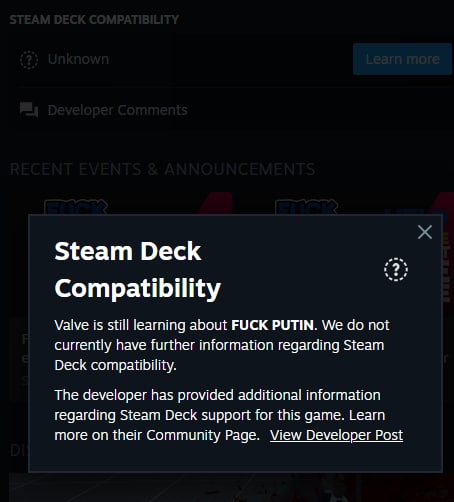

In that case, they say that the game will be ported but it is still not ready. That is why I decided to change it to Dev Notice.

## Metadata Store

The following columns have useful information (mostly only available at the storefront dataframe), and curiously all of them have the same non-null values . It could be interesting to check if all missing are from the same app ids. Since we will be missing crucial information with those games (specially the release date), we could just delete these rows.

* type 
* required_age 
* is_free
* header_image 
* pc_requirements
* mac_requirements
* linux_requirements
* package_groups 
* platforms 
* release_date
* support_info

In [109]:
store[store["type"].notnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66216 entries, 10 to 1973640
Data columns (total 70 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   type                        66216 non-null  object 
 1   name                        66216 non-null  object 
 2   required_age                66216 non-null  object 
 3   is_free                     66216 non-null  bool   
 4   controller_support          66216 non-null  object 
 5   dlc                         9516 non-null   object 
 6   detailed_description        66190 non-null  object 
 7   about_the_game              66189 non-null  object 
 8   short_description           66191 non-null  object 
 9   fullgame                    0 non-null      float64
 10  supported_languages         66209 non-null  object 
 11  header_image                66216 non-null  object 
 12  website                     35123 non-null  object 
 13  pc_requirements             

In [110]:
store[store["type"].isnull()]

Empty DataFrame
Columns: [type, name, required_age, is_free, controller_support, dlc, detailed_description, about_the_game, short_description, fullgame, supported_languages, header_image, website, pc_requirements, mac_requirements, linux_requirements, legal_notice, drm_notice, ext_user_account_notice, developers, publishers, demos, price_overview, packages, package_groups, platforms, metacritic, reviews, genres, screenshots, movies, recommendations, achievements, release_date, support_info, background, content_descriptors, singleplayer, multiplayer, pvp, co-op, online, local_multiplayer, mmo, lan, cloud, trading_cards, leaderboards, workshop, in_app_purchases, level_editor, tag_list, early_access, vr_only, vr_pcinput, vr_supported, Tags - Top-Level Genres, Tags - Genres, Tags - Sub-Genres, Tags - Visuals & Viewpoint, Tags - Themes & Moods, Tags - Features, Tags - Players, Tags - Other Tags, Tags - Software, Tags - Assessments, Tags - Maturity Ratings, Tags - Hardware or Input, Tags - Funding, deck_compatibility]
Index: []

[0 rows x 70 columns]

In [111]:
store["type"].value_counts()

game    66216
Name: type, dtype: int64

It can be useful to at least check the value_counts of each column to detect any strange values.

In [112]:
store["required_age"].value_counts()

0                                                                             48612
0.0                                                                           16573
18                                                                              272
18.0                                                                            242
16.0                                                                            142
16                                                                              119
12                                                                               47
12.0                                                                             45
17.0                                                                             37
15.0                                                                             20
13.0                                                                             18
15                                                                          

In [113]:
getSteamLink(store[store["required_age"]==12.0])

SEGA Mega Drive and Genesis Classics https://store.steampowered.com/app/34270
FINAL FANTASY VII https://store.steampowered.com/app/39140
Kohan II: Kings of War https://store.steampowered.com/app/97130
Hell Yeah! Wrath of the Dead Rabbit https://store.steampowered.com/app/205230
Sine Mora https://store.steampowered.com/app/207040
Tomb Raider I https://store.steampowered.com/app/224960
Tomb Raider IV: The Last Revelation https://store.steampowered.com/app/224980
Tomb Raider V: Chronicles https://store.steampowered.com/app/225000
Tomb Raider VI: The Angel of Darkness https://store.steampowered.com/app/225020
Tomb Raider II https://store.steampowered.com/app/225300
Tomb Raider III https://store.steampowered.com/app/225320
FINAL FANTASY®  XI: Ultimate Collection Seekers Edition https://store.steampowered.com/app/230350
Anachronox https://store.steampowered.com/app/242940
Startopia https://store.steampowered.com/app/243040
Starlight Inception™ https://store.steampowered.com/app/250720
//N.P

This column is really messy. Almost all games have a "0" value, which probably means no restriction, with then some with 18... and a lot of strange age values.

According to PEGI the values should be 3, 7, 12, 16 and 18.

This sounds like something that might be informed by the "content_descriptors" column.

In [114]:
store["content_descriptors"].value_counts()

{'ids': [], 'notes': None}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          54878
{'ids': [2, 5], 'notes': None}                                                                                                                                                                                                                                                                                                                                                                                                                                

In [115]:
getSteamLink(store[store["content_descriptors"]=="{'ids': [2, 5], 'notes': None}"])

Manhunt https://store.steampowered.com/app/12130
Zombie Panic! Source https://store.steampowered.com/app/17500
Penumbra Overture https://store.steampowered.com/app/22180
Painkiller: Black Edition https://store.steampowered.com/app/39530
Mafia https://store.steampowered.com/app/40990
Homefront®: The Revolution https://store.steampowered.com/app/223100
Brothers - A Tale of Two Sons https://store.steampowered.com/app/225080
ASYLUM https://store.steampowered.com/app/230210
Warframe https://store.steampowered.com/app/230410
Kenshi https://store.steampowered.com/app/233860
HITMAN™ https://store.steampowered.com/app/236870
Outlast https://store.steampowered.com/app/238320
Corpse Party https://store.steampowered.com/app/251270
WWII Online https://store.steampowered.com/app/251950
Gunlok https://store.steampowered.com/app/254900
Killer is Dead - Nightmare Edition https://store.steampowered.com/app/261110
Ryse: Son of Rome https://store.steampowered.com/app/302510
Worlds https://store.steampower

4 Minutes to the Apocalypse https://store.steampowered.com/app/1269700
Fall Of The Mafia https://store.steampowered.com/app/1273160
Blind Blade II https://store.steampowered.com/app/1273290
幽灵高校(Ghost College) https://store.steampowered.com/app/1274360
COMMUNION https://store.steampowered.com/app/1274670
炽焰帝国:十字军东征 https://store.steampowered.com/app/1275300
A letter to you! https://store.steampowered.com/app/1275450
Human Farm https://store.steampowered.com/app/1276510
Crysis® 3 https://store.steampowered.com/app/1282690
CONSCRIPT https://store.steampowered.com/app/1286990
TinShift https://store.steampowered.com/app/1288430
Stay in the Light https://store.steampowered.com/app/1296010
Whiskey.Mafia. Leo's Family https://store.steampowered.com/app/1300430
Yuldigard's Fate https://store.steampowered.com/app/1302920
降妖神兵 https://store.steampowered.com/app/1304470
The Insider – interactive movie https://store.steampowered.com/app/1304620
Wolfstride https://store.steampowered.com/app/1331210

Dreamland Prison https://store.steampowered.com/app/1624130
Lost Scale: Part One https://store.steampowered.com/app/1625060
Ghost blood https://store.steampowered.com/app/1625110
Bio Crisis: Evil Hazard https://store.steampowered.com/app/1625950
Rules: Politically Incorrect https://store.steampowered.com/app/1628170
No Fear https://store.steampowered.com/app/1629040
Endless Crawler https://store.steampowered.com/app/1631410
Ragdoll Knight https://store.steampowered.com/app/1631710
Keep Trying! Zombie Apocalypse https://store.steampowered.com/app/1634830
ACHERON https://store.steampowered.com/app/1634900
The Altered Lands https://store.steampowered.com/app/1634940
Regiment of Armour https://store.steampowered.com/app/1635830
S.T.A.L.K.E.R. 2: Heart of Chornobyl https://store.steampowered.com/app/1643320
Knight of Exile https://store.steampowered.com/app/1644430
Mad Mustache https://store.steampowered.com/app/1644630
Dangerous Planet https://store.steampowered.com/app/1644640
Orc Scrolls

It seems that content descriptor [2,5] adds this statement: 

The developers describe the content like this:

This Game may contain content not appropriate for all ages, or may not be appropriate for viewing at work: Frequent Violence or Gore, General Mature Content

They may add a note, but the keynote here is that [2] is frequent violence or gore, [5] means mature content.
More details here:
https://steamcommunity.com/games/593110/announcements/detail/1708442022337025126

Honestly, seeing the stats from pegi https://pegi.info/page/statistics-about-pegi (around 16% of games are 18+), only about a thousand +18 seems bad.

Anyhow, it seems these two columns should be simplified to +18 or nothing, since everything seems to be quite unregulated, and probably popular titles which are +18 are at least correctly rated. It is unclear if this information would be useful, but this is the only source available and this makes the most sensible choice to at least show some value.

Let's check a very popular +18 title and see if it makes sense.
https://store.steampowered.com/app/271590/Grand_Theft_Auto_V/

In [116]:
print(store.loc[271590]["required_age"], store.loc[271590]["content_descriptors"])

17.0 {'ids': [5], 'notes': None}


It seems it might make sense to put as +18 any title with required age 17 or more, OR if it has the id 5 which means mature content.

In [117]:
store["is_free"].value_counts()

False    58580
True      7636
Name: is_free, dtype: int64

In [118]:
store["pc_requirements"].value_counts()

{'minimum': '<strong>Minimum:</strong><br><ul class="bb_ul"><li><strong>OS:</strong> Windows 7</li></ul>'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

This could be useful information, but it is html formatted, and not standard. We will keep not clean it at all, and we will separate it from our main table at the end, in case someone needs this information. The same happens with the mac and linux requirements.

If a developer wants to look what systems the users have, it is better to just use the steam survey: https://store.steampowered.com/hwsurvey

In [119]:
print(store.iloc[0]["header_image"])

https://cdn.akamai.steamstatic.com/steam/apps/10/header.jpg?t=1602535893


This column just gives us a link to a header image. This could be useful in the visualization phase, if we want to highlight any particular game.

In [120]:
store.iloc[0]["package_groups"]

"[{'name': 'default', 'title': 'Buy Counter-Strike', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 7, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Counter-Strike: Condition Zero - 8,19€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 819}, {'packageid': 574941, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Counter-Strike - Commercial License - 8,19€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 819}]}]"

This seems the information about in which packs is this game available. Let's try looking for a game which is by itself and in a pack to confirm it.
https://store.steampowered.com/app/413410/Danganronpa_Trigger_Happy_Havoc/

In [121]:
store.loc[413410]["package_groups"]

"[{'name': 'default', 'title': 'Buy Danganronpa: Trigger Happy Havoc', 'description': '', 'selection_text': 'Select a purchase option', 'save_text': '', 'display_type': 0, 'is_recurring_subscription': 'false', 'subs': [{'packageid': 82833, 'percent_savings_text': ' ', 'percent_savings': 0, 'option_text': 'Danganronpa: Trigger Happy Havoc - 19,99€', 'option_description': '', 'can_get_free_license': '0', 'is_free_license': False, 'price_in_cents_with_discount': 1999}]}]"

Well... the packs are not visible here, only the game by itself. We have some metadata related to the buy box, and also a discount which was present at the time. Depending on how the price_overview is, this might be useful to complete it. But the format is a bit messy (not standard, see those two examples), so it would be best to avoid it and erase this column.

In [122]:
store["platforms"].value_counts()

{'windows': True, 'mac': False, 'linux': False}    49622
{'windows': True, 'mac': True, 'linux': True}       7889
{'windows': True, 'mac': True, 'linux': False}      6746
{'windows': True, 'mac': False, 'linux': True}      1942
{'windows': False, 'mac': True, 'linux': False}       11
{'windows': False, 'mac': False, 'linux': True}        5
{'windows': False, 'mac': True, 'linux': True}         1
Name: platforms, dtype: int64

We will need to change the format to separated comma values, but the information is good.

In [123]:
store["release_date"].value_counts()

{'coming_soon': True, 'date': '2022'}                   1202
{'coming_soon': True, 'date': 'TBA'}                     881
{'coming_soon': True, 'date': 'Coming Soon'}             704
{'coming_soon': True, 'date': ''}                        419
{'coming_soon': True, 'date': 'TBD'}                     280
                                                        ... 
{'coming_soon': True, 'date': 'Kicked to 2022'}            1
{'coming_soon': True, 'date': '3 Jan, 2024'}               1
{'coming_soon': True, 'date': 'Grand opening soon!'}       1
{'coming_soon': True, 'date': 'As Fast As I Can'}          1
{'coming_soon': False, 'date': '4 Jun, 2017'}              1
Name: release_date, Length: 6576, dtype: int64

Here we have two different fields, one if the game has already released or not (coming_soon) and we also have the date. The date seems to be free text for the unreleased games, but we should check if it has always the same format for the already released.

In [124]:
store["release_date"].sample(n=10)

id
805990                  {'coming_soon': True, 'date': ''}
1165740    {'coming_soon': False, 'date': '20 Feb, 2020'}
937420              {'coming_soon': True, 'date': '2019'}
1137730     {'coming_soon': False, 'date': '5 Sep, 2019'}
1636560         {'coming_soon': True, 'date': 'Dec 2022'}
463140                  {'coming_soon': True, 'date': ''}
790570     {'coming_soon': False, 'date': '12 Mar, 2018'}
437090     {'coming_soon': False, 'date': '14 Apr, 2016'}
1020910    {'coming_soon': True, 'date': 'July 15, 2022'}
355650     {'coming_soon': False, 'date': '16 Mar, 2015'}
Name: release_date, dtype: object

After testing a few, it looks like that, free text if it is not released, but formated in  day Month, year otherwise. We will revisit this when we change it. Since the free text will be troublesome, maybe we can keep this in one columns with the real date if it has been release, and False if it has not released, or has no release information.

In [125]:
store["support_info"].value_counts()

{'url': '', 'email': ''}                                                                     896
{'url': 'https://www.facebook.com/8FloorGames', 'email': 'mikhail.zverev@8floor.net'}        225
{'url': 'https://bigfishgames.custhelp.com/app/home', 'email': 'info@bigfishgames.com'}      205
{'url': '', 'email': 'support@quanticlab.com'}                                               134
{'url': '', 'email': 'mail@garage-games.ru'}                                                 122
                                                                                            ... 
{'url': 'https://www.trencheswip.com/', 'email': 'trenchesprototype@gmail.com'}                1
{'url': '', 'email': 'couchMonsters@posteo.de'}                                                1
{'url': 'https://www.threeguysgamestudio.com/', 'email': 'threeguysgamestudio@gmail.com'}      1
{'url': 'https://sailaway.world', 'email': 'support@sailaway.world'}                           1
{'url': 'https://livemotiongam

This information is listed on each steam store page, but it does not seem to be mandatory. That makes sense, as steam hosts a forum for each game, called "steam discussions". We can safely delete this column as it has no use for our analysis. It could be perhaps used to enrich developer or publisher data, but we have those columns quite clean. 

In case it is useful for anybody, we will keep it separated.

In [126]:
store["website"].value_counts()

https://www.facebook.com/8FloorGames/                 201
https://www.choiceofgames.com/                        152
http://www.exosyphen.com                               85
https://steamcommunity.com/groups/alawargames          72
https://www.facebook.com/DnovelGames/                  71
                                                     ... 
https://roethigh.wixsite.com/reatelier                  1
http://www.blueshieldalliance.com                       1
https://weibo.com/bubbleutopia                          1
https://linktr.ee/affordablecaregames                   1
http://3000ad.com/games/galcom-echo-squad-se-2014/      1
Name: website, Length: 29269, dtype: int64

In [127]:
store["ext_user_account_notice"].value_counts()

Uplay (Supports Linking to Steam Account)                         38
EA Account (Supports Linking to Steam Account)                    29
Slitherine PBEM++ for Multiplayer                                 27
Twitch                                                            23
Ubisoft Account (Supports Linking to Steam Account)               22
                                                                  ..
www.pararea.com                                                    1
Playdek Account is required for online play                        1
Oculus Store (Rift)                                                1
Kepithor Studios account. Can register on website or in game.      1
3rd Party Account                                                  1
Name: ext_user_account_notice, Length: 701, dtype: int64

### Metadata Store First Columns

We can confirm that there is a group of "metadata" columns had the same rows with nans, so we will drop those rows. Looking at the IDs directly on steam, we cannot even catch its webpage - they mostly seem betas,old non-functional demos or tests...

* To clean the following columns from NaN, we will simply keep the rows with values from any of the columns as the missing info is from the same rows. 
`type  required_age  is_free  header_image  pc_requirements  mac_requirements  linux_requirements package_groups  platforms  release_date  support_info legal_info` 

Additional cleaning required:

`type`
* We will drop the only 2 app_ids which are not games. And then drop this column as we will not need it anymore.

`required_age content_descriptors`
* A new column will be created with Mature being True or False. If the game is 17+, or it has an id in content_descriptors of a mature game, it will be considered Mature.

`is_free`
* Already clean, True or False.

`header_image`
* Will be kept to aid our visualizations. Might be interested for Image based ML.

`pc_requirements  mac_requirements  linux_requirements`
* We will not treat this, it will be separated from the main dataframe as it is not useful and poorly formatted.

`package_groups`
* Eventually this will be dropped, but we will see if it could be used for any errors in the price column.

`platforms`
* We need to change it into separated comma values.

`release_date`
* The format will be changed to a single date if it has been released, or False if it has not been released yet.

`support_info`
* We will not treat this, it will be separated from the main dataframe as it is not useful.

`legal_info`
* This we will simply delete.

After some review, as we have a few additional columns that is clear that we will not use, but could be useful for a ML image oriented approach... we will also separate `movies`, `screenshots`, `background`, `website` in this step.

### Metadata Store Columns with a lot of NaNs

Next we have the following columns:

* `metacritic` : The numeric value if available, False if it has no value.
* `reviews` : It is free text, so we will change it to True or False. Meaning True = there was a profesional review linked.
* `recommendations` : After inspecting this, it seems linked to the user reviews on Steam. But we got only the total recommendations and also we have tons of NaN, which makes no sense. We will get this information from other places.



* `demos`
* `drm_notice`
* `dlc`

In this case, this group deals with features. The game may have a demo, it uses DRM, it has DLC. We will check these and see if they can be turned into a True / False column with no NaNs.

* `fullgame`: Useless column filled with NaNs.
* `legal_notice`: This has no useful information for us, we will just drop it.
* `ext_user_account_notice`: This tells us if we need to link an external account (such as uplay for Ubisoft, or Origin in case of EA). It is not clear if it will be useful but we will keep it anyway. Let's add False for all these cases where we got no notice.

In [128]:
def isAgeMature(age):
    age = str(age)
    try:
        x = re.search("\d+", age).group()
        x = int(x)
    except:
        return False
    if 16 < x < 30:
        return True
    else:
        return False

def isDescriptorMature(descriptor):
    try :
        ids = eval(descriptor)["ids"]
        if 5 in ids:
            return True
        else:
            return False
    except :
        return False

def getMatureMetadata(store):
    store["required_age"] = store["required_age"].apply(isAgeMature)
    store["content_descriptors"] = store["content_descriptors"].apply(isDescriptorMature)
    store["mature"] = store["required_age"] | store["content_descriptors"]
    store = store.drop(columns=["required_age", "content_descriptors"])
    return store

def getMyPlatform(value):
    if value == "{'windows': True, 'mac': False, 'linux': False}":
        return "Windows"
    elif value == "{'windows': True, 'mac': True, 'linux': True}":
        return "Windows, Mac, Linux"
    elif value == "{'windows': True, 'mac': True, 'linux': False}":
        return "Windows, Mac"
    elif value == "{'windows': False, 'mac': True, 'linux': False}":
        return "Mac"
    elif value == "{'windows': False, 'mac': False, 'linux': True}":
        return "Linux"
    elif value == "{'windows': True, 'mac': False, 'linux': True}":
        return "Windows, Linux"
    else:
        return "Mac, Linux"

def getPlatforms(store):
    store["platforms"] = store["platforms"].apply(getMyPlatform)
    return store

def getReleaseDate(value):
    if extractDict(value,"coming_soon") == True:
        return "coming_soon"
    else:
        thisDate = extractDict(value, "date")
        if (thisDate == np.NaN or thisDate == ""):
            return "unknown"
        else:
            return pd.to_datetime(thisDate)

def getMetacritic(value):
    try :
        score = eval(value)["score"]
        return int(score)
    except :
        return False
    
def getCleanMetadata(store):
    # This takes care of both cleaning the NaN without these metadata, and the types we do not want
    store = store[store["type"]=="game"].copy()
    
    store = getMatureMetadata(store)
    
    extra = store.loc[:,["name","support_info", "header_image", "website",
                         "pc_requirements","mac_requirements","linux_requirements",
                         "background","screenshots","movies"]].copy()
    
    store = getPlatforms(store)
    
    store["metacritic"] = store["metacritic"].apply(getMetacritic)
    
    store["demos"] = ~store["demos"].isna()
    
    store["reviews"] = ~store["reviews"].isna()
    
    store["drm_notice"] = ~store["drm_notice"].isna()
    
    store["dlc"] = ~store["dlc"].isna()
    
    store["release_date"] = store["release_date"].apply(getReleaseDate)
    
    store["ext_user_account_notice"] = store["ext_user_account_notice"].fillna(False)
    
    store = store.rename(columns={"drm_notice":"drm"})
    
    store = store.drop(columns=["pc_requirements","mac_requirements","linux_requirements",
                         "background","screenshots","movies","support_info",
                               "website", "fullgame", "type", "legal_notice"])
    
    
    return store, extra

In [129]:
store, extra = getCleanMetadata(store)

In [130]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66216 entries, 10 to 1973640
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   name                        66216 non-null  object
 1   is_free                     66216 non-null  bool  
 2   controller_support          66216 non-null  object
 3   dlc                         66216 non-null  bool  
 4   detailed_description        66190 non-null  object
 5   about_the_game              66189 non-null  object
 6   short_description           66191 non-null  object
 7   supported_languages         66209 non-null  object
 8   header_image                66216 non-null  object
 9   drm                         66216 non-null  bool  
 10  ext_user_account_notice     66216 non-null  object
 11  developers                  66216 non-null  object
 12  publishers                  66216 non-null  object
 13  demos                       66216 non-null 

In [131]:
store["release_date"].value_counts()

coming_soon            10957
2020-01-17 00:00:00       82
2021-09-30 00:00:00       82
2021-10-14 00:00:00       80
2022-01-21 00:00:00       77
                       ...  
2003-11-01 00:00:00        1
2017-03-04 00:00:00        1
2011-07-20 00:00:00        1
2012-12-12 00:00:00        1
2005-07-11 00:00:00        1
Name: release_date, Length: 3733, dtype: int64

We may want to review this column later.

## Reviews and Recommendations

This is one of the more important features we want. What is the number of total reviews / recommendations, which might give us insights on how many copies were sold, and has the game been received positively?

In [132]:
store["recommendations"]

id
10         {'total': 120283}
20           {'total': 4576}
30           {'total': 3170}
40           {'total': 1516}
50          {'total': 11741}
                 ...        
1969810                  NaN
1972920                  NaN
1972970                  NaN
1973220                  NaN
1973640                  NaN
Name: recommendations, Length: 66216, dtype: object

This column is the number of total user reviews in steam. There are some NaNs, and if we check the Steam Store it does not show the same numbers. We have to tackle this column together with the positive/negative reviews from steam spy.

Here we must make a decision. Steam does not give us any metric of success except the number of total reviews. From Steam Spy, we can calculate the ratio of positive / total number of reviews. Should we forget about this column from Steam, and instead only keep records with positive/negative information from Steam Spy?

In [133]:
store["reviews"]

id
10         False
20         False
30         False
40         False
50         False
           ...  
1969810    False
1972920    False
1972970    False
1973220    False
1973640    False
Name: reviews, Length: 66216, dtype: bool

In [134]:
store["metacritic"]

id
10            88
20         False
30            79
40         False
50         False
           ...  
1969810    False
1972920    False
1972970    False
1973220    False
1973640    False
Name: metacritic, Length: 66216, dtype: object

In [135]:
getSteamLink(store.head())

Counter-Strike https://store.steampowered.com/app/10
Team Fortress Classic https://store.steampowered.com/app/20
Day of Defeat https://store.steampowered.com/app/30
Deathmatch Classic https://store.steampowered.com/app/40
Half-Life: Opposing Force https://store.steampowered.com/app/50


I am just going to check Dracula origins to understand what these fields are telling us. 

Ok, so from `reviews` it seems the game has a professional review listed here, chosen by hand as it is a positive one. It might be worth it to make this into a True False (professional reviews) as we cannot get the data about the score.

The same game shows the `metacritic` score, even if it is not a very good one, we might want to parse this into the numeric score or False if it does not have a metacritic score.

Let's get back to user reviews in Steam.

In [136]:
print(spy.loc[10]["name"]+" "+"+"+str(spy.loc[10]["positive"])+"/"+str(spy.loc[10]["positive"]+spy.loc[10]["negative"]))

Counter-Strike +195310/200328


In [137]:
print(store.loc[10]["name"]+" "+str(store.loc[10]["recommendations"]))

Counter-Strike {'total': 120283}


In [138]:
getSteamLink(store[store["name"].str.contains("Counter-Strike")])

Counter-Strike https://store.steampowered.com/app/10
Counter-Strike: Condition Zero https://store.steampowered.com/app/80
Counter-Strike: Source https://store.steampowered.com/app/240
Counter-Strike: Global Offensive https://store.steampowered.com/app/730
Counter-Strike Nexon: Studio https://store.steampowered.com/app/273110


Looking at Steam directly, the number of total recommendations from the Steam Store is actually accurate (around 119k). So why do we have in this case (one of the first games available on Steam) such a huge divergence? Let's try comparing a newer game. Maybe some of these accounts got disabled in time, or steam at some point redid the review system...

https://store.steampowered.com/app/548430/Deep_Rock_Galactic/

97% of 98762 reviews are positive. This was taken almost a month after the data from the APIs.

In [139]:
print(spy.loc[548430]["name"]+" "+"+"+str(spy.loc[548430]["positive"])+"/"+str(spy.loc[548430]["positive"]+spy.loc[548430]["negative"])+" "+str(spy.loc[548430]["positive"]*100/(spy.loc[548430]["positive"]+spy.loc[548430]["negative"])))

Deep Rock Galactic +124302/128225 96.94053421719633


In [140]:
print(store.loc[548430]["name"]+" "+str(store.loc[548430]["recommendations"]))

Deep Rock Galactic {'total': 102762}


At least the percentage matches.
Let's try a newer game, one from 3rd Quarter 2021. It will not make sense checking the webpage directly, as now there will be a lot of newer reviews.

https://store.steampowered.com/app/1551360/Forza_Horizon_5/
(59,855) 86%



In [141]:
print(spy.loc[1551360]["name"]+" "+"+"+str(spy.loc[1551360]["positive"])+"/"+str(spy.loc[1551360]["positive"]+spy.loc[1551360]["negative"])+" "+str(spy.loc[1551360]["positive"]*100/(spy.loc[1551360]["positive"]+spy.loc[1551360]["negative"])))

Forza Horizon 5 +61174/70561 86.6966171114355


In [142]:
print(store.loc[1551360]["name"]+" "+str(store.loc[1551360]["recommendations"]))

Forza Horizon 5 {'total': 65272}


In any case, the metrics are similar, and the most important one (percentage) could be obtained with steam spy and matches the steam store page. As we have a lot of NaNs from steam, we will trust Steam Spy here, although it is puzzling why the numbers do not match. Maybe Steam Spy registers re-reviews as two different reviews?.

Looking for an alternative, it seems possible to get the information from Steam API (partners) directly. Initially I thought it was not going to be possible as it is in the partners side. See this query for example:

https://store.steampowered.com/appreviews/10?json=1?&num_per_page=0?&language=all

Note: it is important to put language=all, otherwise we get fewer results for the totals.

At the end, we went this route and documented everything in the data collection section. As a result we got the following dataset: `steamreviews_data.csv`

In [143]:
steamreviews=pd.read_csv("../data/download/steamreviews_data.csv")

In [144]:
steamreviews

appid  review_score        review_score_desc  total_positive  \
0           10             9  Overwhelmingly Positive          195304   
1           20             8            Very Positive            5523   
2           30             8            Very Positive            5076   
3           40             8            Very Positive            1880   
4           50             9  Overwhelmingly Positive           13700   
...        ...           ...                      ...             ...   
66426  1969810             0          No user reviews               0   
66427  1972920             0          No user reviews               0   
66428  1972970             0          No user reviews               0   
66429  1973220             0          No user reviews               0   
66430  1973640             0          No user reviews               0   

       total_negative  total_reviews  
0                5018         200322  
1                 909           6432  
2                 556           5632  
3                 414           2294  
4                 674          14374  
...               ...            ...  
66426               0              0  
66427               0              0  
66428               0              0  
66429               0              0  
66430               0              0  

[66431 rows x 6 columns]

Here we have several columns but with dependant information. In reality, only total positive and total negative are unique values. What will be important for us later on?

* Total reviews: Gives us insight on number of sales
* Review score: Gives us insight on how well appreciated the game is.

So in that sense, we should only care about two columns. But since this is key information, we will keep total_positive, total_negative, total_reviews and feature a new column for the score.

Let's take steamdb advice on how to calculate the rating: https://steamdb.info/stats/gameratings/
In summary, what will happen is that games with very few reviews will tend to have a 50% rating, and in a logarithmic scale we will get more sure (twice sure) that the actual ratio of positive/total reviews is correct.

So a game with 1 positive review is actually 50% regardless of the review, a game with 10 out of 10 positives reviews will be 50% x 0.5 + 100% x 0.5 = 75%. If we have 100 reviews (all positive) then it would be 87.5%.

Let's see if this might be unfair. Do we have many games below 50% pure rating?

In [145]:
steamreviews["review_score"].value_counts()

0    28538
8    10369
5    10074
7     7633
6     6867
4     1772
9      859
3      254
2       54
1       11
Name: review_score, dtype: int64

Mostly there are unrated games (which at this point means less than 10 reviews), then we have around 26k games between 5 and 8. There are only about 1.5k bad games (1 to 4), and most of them are just bad (4). And we have 746 excellent games.

So it seems that it is reasonable to use the algorithm above to calculate the rating.

In [146]:
steamreviews["rating"] = (steamreviews["total_positive"]/steamreviews["total_reviews"] - (steamreviews["total_positive"]/steamreviews["total_reviews"] -0.5)*np.power(2,-np.log10(steamreviews["total_reviews"]+1)))*100

In [147]:
steamreviews.head()

appid  review_score        review_score_desc  total_positive  \
0     10             9  Overwhelmingly Positive          195304   
1     20             8            Very Positive            5523   
2     30             8            Very Positive            5076   
3     40             8            Very Positive            1880   
4     50             9  Overwhelmingly Positive           13700   

   total_negative  total_reviews     rating  
0            5018         200322  96.290917  
1             909           6432  83.307450  
2             556           5632  87.146850  
3             414           2294  78.842536  
4             674          14374  92.772118

In [148]:
steamreviews.sort_values(by="rating", ascending=False).head()

appid  review_score        review_score_desc  total_positive  \
23         620             9  Overwhelmingly Positive          288540   
7862    427520             9  Overwhelmingly Positive          133016   
33964  1118200             9  Overwhelmingly Positive          107486   
35105  1145360             9  Overwhelmingly Positive          183492   
60999  1794680             9  Overwhelmingly Positive           78764   

       total_negative  total_reviews     rating  
23               3509         292049  97.694055  
7862             1474         134490  97.506179  
33964            1213         108699  97.394332  
35105            2532         186024  97.377974  
60999             850          79614  97.294591

Let's see which are these fantastic games!

In [149]:
store.loc[steamreviews.sort_values(by="rating", ascending=False).head()["appid"]]

name  is_free controller_support    dlc  \
id                                                              
620               Portal 2    False               full   True   
427520            Factorio    False               none   True   
1118200  People Playground    False               none  False   
1145360              Hades    False               full   True   
1794680  Vampire Survivors    False               full  False   

                                      detailed_description  \
id                                                           
620      Portal 2 draws from the award-winning formula ...   
427520   <strong>Factorio</strong> is a game in which y...   
1118200  <img src="https://cdn.akamai.steamstatic.com/s...   
1145360  <img src="https://cdn.akamai.steamstatic.com/s...   
1794680  Vampire Survivors is a time survival game with...   

                                            about_the_game  \
id                                                           
620      Portal 2 draws from the award-winning formula ...   
427520   <strong>Factorio</strong> is a game in which y...   
1118200  <img src="https://cdn.akamai.steamstatic.com/s...   
1145360  <img src="https://cdn.akamai.steamstatic.com/s...   
1794680  Vampire Survivors is a time survival game with...   

                                         short_description  \
id                                                           
620      The &quot;Perpetual Testing Initiative&quot; h...   
427520   Factorio is a game about building and creating...   
1118200  Shoot, stab, burn, poison, tear, vaporise, or ...   
1145360  Defy the god of the dead as you hack and slash...   
1794680  Mow down thousands of night creatures and surv...   

                                       supported_languages  \
id                                                           
620      English<strong>*</strong>, French<strong>*</st...   
427520   English, French, Italian, German, Spanish - Sp...   
1118200                                            English   
1145360  English<strong>*</strong>, French, Italian, Ge...   
1794680                                            English   

                                              header_image    drm  ...  \
id                                                                 ...   
620      https://cdn.akamai.steamstatic.com/steam/apps/...  False  ...   
427520   https://cdn.akamai.steamstatic.com/steam/apps/...  False  ...   
1118200  https://cdn.akamai.steamstatic.com/steam/apps/...  False  ...   
1145360  https://cdn.akamai.steamstatic.com/steam/apps/...  False  ...   
1794680  https://cdn.akamai.steamstatic.com/steam/apps/...  False  ...   

                                           Tags - Features  \
id                                                           
620      Level Editor,Physics,Story Rich,Female Protago...   
427520   Automation,Base Building,Building,Crafting,Mod...   
1118200                          Building,Moddable,Physics   
1145360              Hack and Slash,Perma Death,Story Rich   
1794680                                       Score Attack   

                         Tags - Players Tags - Other Tags  Tags - Software  \
id                                                                           
620                               Co-op                                      
427520   Co-op,Multiplayer,Singleplayer                                      
1118200                    Singleplayer             Indie                    
1145360                    Singleplayer             Indie                    
1794680                    Singleplayer             Indie                    

                              Tags - Assessments Tags - Maturity Ratings  \
id                                                                         
620                                 Funny,Comedy                           
427520                                                                     
1118200              

This correlates with what we see at https://steamdb.info/stats/gameratings/ . As you can see, the numbers of reviews are slightly different, but we decided to go with the reviews extracted directly from Steam.

In [150]:
steamreviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66431 entries, 0 to 66430
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   appid              66431 non-null  int64  
 1   review_score       66431 non-null  int64  
 2   review_score_desc  66431 non-null  object 
 3   total_positive     66431 non-null  int64  
 4   total_negative     66431 non-null  int64  
 5   total_reviews      66431 non-null  int64  
 6   rating             53216 non-null  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 3.5+ MB


In the mathematical operations we got a lot of NaNs, due to games with 0 total reviews. Let's assign them a score of 50%, as the medium point. This is the same approach used in the algorithm above.

In [151]:
steamreviews["rating"] = steamreviews["rating"].fillna(50.0)

In [152]:
steamreviews = steamreviews.rename(columns={"appid":"id"})
steamreviews = steamreviews.set_index("id")

In [153]:
steamreviews = steamreviews.drop(["review_score", "review_score_desc"], axis=1)

In [154]:
store = store.join(steamreviews)
store = store.drop(columns=["recommendations"])

In [155]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66216 entries, 10 to 1973640
Data columns (total 61 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        66216 non-null  object 
 1   is_free                     66216 non-null  bool   
 2   controller_support          66216 non-null  object 
 3   dlc                         66216 non-null  bool   
 4   detailed_description        66190 non-null  object 
 5   about_the_game              66189 non-null  object 
 6   short_description           66191 non-null  object 
 7   supported_languages         66209 non-null  object 
 8   header_image                66216 non-null  object 
 9   drm                         66216 non-null  bool   
 10  ext_user_account_notice     66216 non-null  object 
 11  developers                  66216 non-null  object 
 12  publishers                  66216 non-null  object 
 13  demos                       

In [156]:
getSteamLink(store[store["total_reviews"].isna()])

At this point, there may be some errors with the reviews - there are three options, leave them as is / ignore the rows, download all reviews again, or try downloading just these NaN reviews.

Some of them will be due to the not being coordinated between the download of all data from the Steam Store and the reviews (games close to release), but one option is to redownload the NaNs from the API (here it is already corrected)

In [157]:
try:
    print(store[store["total_reviews"].isna()].index.values)
    pd.Series(store[store["total_reviews"].isna()].index.values).to_csv("../data/download/steamreviews_errors.csv", index=False, index_label=False, header=False)
except:
    print("Error, possibly no NaNs found or file error")

[]


We still have two important features left: Price and Language. and we will also need to do a bit further cleaning with the few NaNs lost in there. Let's go with Price first.

## Price

The information for price is stored in `price_overview`. We also noticed that there was information on `package_groups`. Let's try getting the information form overview and see if we need extra from other sources.

In [158]:
print(store.loc[1091500]["price_overview"])

{'currency': 'EUR', 'initial': 5999, 'final': 2999, 'discount_percent': 50, 'initial_formatted': '59,99€', 'final_formatted': '29,99€'}


In [159]:
def getEur(descriptor):
    try :
        currency = eval(descriptor)["currency"]
        if currency == "EUR":
            return eval(descriptor)["initial"]/100
        else:
            return "other"
    except :
        return "error"

In [160]:
store["price"] = store["price_overview"].apply(getEur)

In [161]:
store[store["price"]=="other"]["price_overview"]

Series([], Name: price_overview, dtype: object)

First time we had three 3 games, we could simply use USD, as it is quite common that the price is the same due to taxes. So we can remove the currency check. Let's check errors, which should be free games but maybe we got multiple currencies there.

First, are we sure all the games have a correct price? Let's check the higher values.

In [162]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
store[(store["price"]!="error")].sort_values(by="price",ascending=False)[["name", "price", "price_overview"]].head(100)

name  \
id                                                                       
1462740                                                       Your way   
1556670                                                     I'm a King   
1200520                              Ascent Free-Roaming VR Experience   
1863470                                                Claus Adventure   
1863480                                             Monster Phenomenon   
1235950                                                      Introvert   
1289890                                                 VR Long March    
1255220                                                    Super Fight   
951030                                           Derelict (DO NOT BUY)   
1720060                                              Earthquake escape   
1699510                                         Reincarnation of Ocean   
985660                                                Luna and Cynthia   
1259300                                  Spot Sample Witness Simulator   
865150                                                            安全教育   
1634660                                                          fight   
639440                             VRemedies - CT Procedure Experience   
1022640                                             Lgnorant girl doll   
642690                        VRemedies - Theatre Procedure Experience   
642660                            VRemedies - MRI Procedure Experience   
1787140                                                     RagingFist   
1741550                                                      来自女巫森林的法师   
1177730                                                     W.H.A.L.E.   
1468060                                     The Island of Dr. Yepstein   
947490                 Jam Studio VR - Education & Health Care Edition   
1103060                                                      Run Thief   
1332280                                  COVID-19  Epidemic Prevention   
1170830                                                    ZLM Crafter   
642670                   VRemedies - Radiotherapy Procedure Experience   
873180                         飞跃跳台：冒险！！！ / 1000 Stages : Adventure!!!   
1691000                                                  marriedbook 💍   
881970                                         Voice Shooter "Pif Paf"   
1063220                                     ChessBase 15 Steam Edition   
1497080                                     ChessBase 16 Steam Edition   
255163                Call of Duty®: Ghosts - Digital Hardened Edition   
1250810                                                        Festoon   
561690                                                     Emission VR   
1905060                                        Fire Safety VR Training   
1911120                                           Hot Work VR Training   
1236250                                                     Cult达人极限攀岩   
993640                                                  Boy Teen Dream   
1262730                                            Submarine Adventure   
1738620                               Confined Space Entry VR Training   
1911230                              Lockout Tagout (LOTO) VR Training   
1289260                                                          就这消消乐   
1910210                                     Work At Height VR Training   
881510                      The Official GamingTaylor Game, Great Job!   
1016120                                                  PGA TOUR 2K21   
1507210                                                   aerofly RC 8   
1680880                                                      Forspoken   
1487230                                                   FutureKreate   
904960                                                     Cine Tracer   
873820                                                The Brink 尘与土的边缘   
479330                   Crazy Stone Deep Learning -The First Edition-

In [163]:
pd.reset_option("display.max_colwidth")
pd.reset_option("display.max_rows")


Only the first two games seem to have a wrong price that is different now. We will change them since they are false outliers. 

In [164]:
store[store["price"]=="error"]

name  is_free controller_support  \
id                                                                              
340                       Half-Life 2: Lost Coast    False               none   
440                               Team Fortress 2     True            partial   
570                                        Dota 2     True               none   
630                                   Alien Swarm     True               none   
730              Counter-Strike: Global Offensive     True               full   
...                                           ...      ...                ...   
1969810                    Enter the Chronosphere    False               full   
1972920                              Wife Massage    False               none   
1972970                       Late photographer 4    False               none   
1973220                           Succubus Racing    False               none   
1973640  The Divine Speaker: The Sun and the Moon    False               none   

           dlc                               detailed_description  \
id                                                                  
340      False  Originally planned as a section of the Highway...   
440       True  <p><strong>"The most fun you can have online"<...   
570       True  <strong>The most-played game on Steam.</strong...   
630      False  Alien Swarm is a game and Source SDK release f...   
730       True  Counter-Strike: Global Offensive (CS: GO) expa...   
...        ...                                                ...   
1969810  False  <i>Enter the Chronosphere is in early developm...   
1972920  False  <img src="https://cdn.akamai.steamstatic.com/s...   
1972970  False  A simple and easy beauty dynamic jigsaw puzzle...   
1973220  False  <h2 class="bb_tag">Introduction to gameplay</h...   
1973640  False  <h1>Check out the game that started it all!</h...   

                                            about_the_game  \
id                                                           
340      Originally planned as a section of the Highway...   
440      <p><strong>"The most fun you can have online"<...   
570      <strong>The most-played game on Steam.</strong...   
630      Alien Swarm is a game and Source SDK release f...   
730      Counter-Strike: Global Offensive (CS: GO) expa...   
...                                                    ...   
1969810  <i>Enter the Chronosphere is in early developm...   
1972920  <img src="https://cdn.akamai.steamstatic.com/s...   
1972970  A simple and easy beauty dynamic jigsaw puzzle...   
1973220  <h2 class="bb_tag">Introduction to gameplay</h...   
1973640  <img src="https://cdn.akamai.steamstatic.com/s...   

                                         short_description  \
id                                                           
340      Originally planned as a section of the Highway...   
440      Nine distinct classes provide a broad range of...   
570      Every day, millions of players worldwide enter...   
630      Co-operative multiplayer game and complete cod...   
730      Counter-Strike: Global Offensive (CS: GO) expa...   
...                                                    ...   
1969810  A tactical bullet hell roguelike where each tu...   
1972920  “WIFE MASSAGE” is the new game, with one beati...   
1972970  A simple and easy beauty dynamic jigsaw puzzle...   
1973220  A racing game featuring a sexy succubus. Every...   
1973640  The story-rich 18+ prequel to The Divine Speak...   

                                       supported_languages  \
id                                                           
340      English, French, German, Italian, Spanish - Sp...   
440      English<strong>*</strong>, Danish, Dutch, Finn...   
570      Bulgarian, Czech, Danish, Dutch, English<stron...   
630                                                English   
730      Czech, Danish, Dutch, English<strong>*</strong...   
...                                          

In [165]:
store[store["price"]=="error"]["price_overview"].isna().sum()

18054

In [166]:
store["price_overview"].isna().sum()

18054

It is all NaNs. Let's try to understand if all of these are free games, or coming soon without price. There may be other cases with valid prices - such as the game only available inside a bundle.

In [167]:
store["is_free"].sum()

7636

In [168]:
store["is_free"] = store["is_free"].astype("boolean")

In [169]:
store[(store["price_overview"].isna()) &~(store["is_free"])]

name  is_free controller_support  \
id                                                                              
340                       Half-Life 2: Lost Coast    False               none   
2420                      The Ship: Single Player    False               none   
2570                     Vigil: Blood Bitterness™    False               none   
2700            RollerCoaster Tycoon® 3: Platinum    False               none   
3400                          Hammer Heads Deluxe    False               none   
...                                           ...      ...                ...   
1969810                    Enter the Chronosphere    False               full   
1972920                              Wife Massage    False               none   
1972970                       Late photographer 4    False               none   
1973220                           Succubus Racing    False               none   
1973640  The Divine Speaker: The Sun and the Moon    False               none   

           dlc                               detailed_description  \
id                                                                  
340      False  Originally planned as a section of the Highway...   
2420     False  For PC gamers who enjoy multiplayer games with...   
2570     False  <p>Vigil: Blood Bitterness plunges you into th...   
2700     False  Rollercoaster Tycoon 3 Platinum combines the e...   
3400     False  Pesky yard gnomes are invading your lawn! The ...   
...        ...                                                ...   
1969810  False  <i>Enter the Chronosphere is in early developm...   
1972920  False  <img src="https://cdn.akamai.steamstatic.com/s...   
1972970  False  A simple and easy beauty dynamic jigsaw puzzle...   
1973220  False  <h2 class="bb_tag">Introduction to gameplay</h...   
1973640  False  <h1>Check out the game that started it all!</h...   

                                            about_the_game  \
id                                                           
340      Originally planned as a section of the Highway...   
2420     For PC gamers who enjoy multiplayer games with...   
2570     <p>Vigil: Blood Bitterness plunges you into th...   
2700     Rollercoaster Tycoon 3 Platinum combines the e...   
3400     Pesky yard gnomes are invading your lawn! The ...   
...                                                    ...   
1969810  <i>Enter the Chronosphere is in early developm...   
1972920  <img src="https://cdn.akamai.steamstatic.com/s...   
1972970  A simple and easy beauty dynamic jigsaw puzzle...   
1973220  <h2 class="bb_tag">Introduction to gameplay</h...   
1973640  <img src="https://cdn.akamai.steamstatic.com/s...   

                                         short_description  \
id                                                           
340      Originally planned as a section of the Highway...   
2420     The Ship is a murder mystery alternative to tr...   
2570     Vigil: Blood Bitterness plunges you into the d...   
2700     Rollercoaster Tycoon 3 Platinum combines the e...   
3400     Pesky yard gnomes are invading your lawn! The ...   
...                                                    ...   
1969810  A tactical bullet hell roguelike where each tu...   
1972920  “WIFE MASSAGE” is the new game, with one beati...   
1972970  A simple and easy beauty dynamic jigsaw puzzle...   
1973220  A racing game featuring a sexy succubus. Every...   
1973640  The story-rich 18+ prequel to The Divine Speak...   

                                       supported_languages  \
id                                                           
340      English, French, German, Italian, Spanish - Sp...   
2420     English, French, German, Italian, Spanish - Sp...   
2570                                               English   
2700     English, French, Italian, German, Spanish - Sp...   
3400                                               English   
...                                          

Looking at some of these games, there are coming soon, but also a ton of not available anymore games. These are part of games which had online multiplayer and it has been discontinued, and similar things.
Let's try getting new values from Steam Spy. Our new function should look like this, so we have NaNs where there is no price.

In [170]:
def getEur(descriptor):
    try :
        return eval(descriptor)["initial"]/100
    except :
        return np.NaN

In [171]:
store["initialprice"] = store["price_overview"].apply(getEur)

Let's see how prices are managed in Steam Spy.

In [172]:
spy["initialprice"].value_counts()

0.0       10140
999.0      6529
499.0      6454
99.0       5915
199.0      4484
          ...  
1996.0        1
1969.0        1
565.0         1
2397.0        1
145.0         1
Name: initialprice, Length: 170, dtype: int64

So Steam Spy counts on cents instead of full currency, let's divide it by 100.

We need to make a few changes here to make the fillna function work. It needs a dataframe, so we cannot simply pass the price column, we will add a second one. Also, we should make sure we pass the initialprice column, not price... but they should be named the same.

Let's also change any game with the tag "is free" to initialprice = 0.0. Then we can forget about that column.

In [173]:
spy["initialprice"] = spy["initialprice"]/100

In [174]:
store["initialprice"] = store["initialprice"].where(~store["is_free"], 0.0)

In [175]:
store = updateFromAlternateSource(store,spy[["initialprice","name"]])

In [176]:
store[store["initialprice"].isna()]

name  is_free controller_support  \
id                                                                              
247710                                Battledroid    False               none   
306910                                Project F4E    False               none   
311810                      Operation: Black Mesa    False               full   
315210     Suicide Squad: Kill the Justice League    False               none   
355750                                  Miegakure    False               full   
...                                           ...      ...                ...   
1969810                    Enter the Chronosphere    False               full   
1972920                              Wife Massage    False               none   
1972970                       Late photographer 4    False               none   
1973220                           Succubus Racing    False               none   
1973640  The Divine Speaker: The Sun and the Moon    False               none   

           dlc                               detailed_description  \
id                                                                  
247710   False  BATTLEDROID is a multiplayer battle simulation...   
306910   False  <h1>Join our Discord!</h1><p><a href="https://...   
311810   False  <h1>Join Our Community</h1><p><a href="https:/...   
315210   False  Jump into Suicide Squad: Kill the Justice Leag...   
355750   False  Miegakure is a puzzle/adventure game, the firs...   
...        ...                                                ...   
1969810  False  <i>Enter the Chronosphere is in early developm...   
1972920  False  <img src="https://cdn.akamai.steamstatic.com/s...   
1972970  False  A simple and easy beauty dynamic jigsaw puzzle...   
1973220  False  <h2 class="bb_tag">Introduction to gameplay</h...   
1973640  False  <h1>Check out the game that started it all!</h...   

                                            about_the_game  \
id                                                           
247710   BATTLEDROID is a multiplayer battle simulation...   
306910   <h2 class="bb_tag"><u><strong>🌐Join the F4E PR...   
311810   <strong>Operation: Black Mesa</strong> is a fa...   
315210   Jump into Suicide Squad: Kill the Justice Leag...   
355750   Miegakure is a puzzle/adventure game, the firs...   
...                                                    ...   
1969810  <i>Enter the Chronosphere is in early developm...   
1972920  <img src="https://cdn.akamai.steamstatic.com/s...   
1972970  A simple and easy beauty dynamic jigsaw puzzle...   
1973220  <h2 class="bb_tag">Introduction to gameplay</h...   
1973640  <img src="https://cdn.akamai.steamstatic.com/s...   

                                         short_description  \
id                                                           
247710   Become the commander of a mighty army of fears...   
306910   F4E is a unique blend of MMO, ARPG, MOBA and R...   
311810   Experience the Half-Life™ expansion packs like...   
315210   Don't Be A Hero. Jump into Suicide Squad: Kill...   
355750   Miegakure is a game where you navigate a four-...   
...                                                    ...   
1969810  A tactical bullet hell roguelike where each tu...   
1972920  “WIFE MASSAGE” is the new game, with one beati...   
1972970  A simple and easy beauty dynamic jigsaw puzzle...   
1973220  A racing game featuring a sexy succubus. Every...   
1973640  The story-rich 18+ prequel to The Divine Speak...   

                                       supported_languages  \
id                                                           
247710                                             English   
306910                                             English   
311810   English<strong>*</strong><br><strong>*</strong...   
315210   English<strong>*</strong><br><strong>*</strong...   
355750   English, French, Italian, German, Spanish - Spain   
...                                          

Let's check if we have any ids from games that might be recovered by the package groups. It is possible most of these values have been corrected updating with Steam Spy.

In [177]:
store[store["initialprice"].isna() & (store["package_groups"] != "[]")]["package_groups"]

Series([], Name: package_groups, dtype: object)

Let's check if we have any outliers now that we have added some missing prices with Steam Spy.

In [178]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
store.sort_values(by="initialprice",ascending=False)[["name", "initialprice", "price_overview"]].head(100)

name  \
id                                                                       
1556670                                                     I'm a King   
1462740                                                       Your way   
1200520                              Ascent Free-Roaming VR Experience   
1863470                                                Claus Adventure   
1863480                                             Monster Phenomenon   
1235950                                                      Introvert   
1177730                                                     W.H.A.L.E.   
639440                             VRemedies - CT Procedure Experience   
947490                 Jam Studio VR - Education & Health Care Edition   
1634660                                                          fight   
1720060                                              Earthquake escape   
1289890                                                 VR Long March    
1255220                                                    Super Fight   
865150                                                            安全教育   
1170830                                                    ZLM Crafter   
1332280                                  COVID-19  Epidemic Prevention   
1741550                                                      来自女巫森林的法师   
1699510                                         Reincarnation of Ocean   
1468060                                     The Island of Dr. Yepstein   
1103060                                                      Run Thief   
1787140                                                     RagingFist   
642690                        VRemedies - Theatre Procedure Experience   
642670                   VRemedies - Radiotherapy Procedure Experience   
985660                                                Luna and Cynthia   
1022640                                             Lgnorant girl doll   
642660                            VRemedies - MRI Procedure Experience   
951030                                           Derelict (DO NOT BUY)   
1259300                                  Spot Sample Witness Simulator   
1691000                                                  marriedbook 💍   
873180                         飞跃跳台：冒险！！！ / 1000 Stages : Adventure!!!   
881970                                         Voice Shooter "Pif Paf"   
1497080                                     ChessBase 16 Steam Edition   
863550                                                       HITMAN™ 2   
255163                Call of Duty®: Ghosts - Digital Hardened Edition   
1063220                                     ChessBase 15 Steam Edition   
1250810                                                        Festoon   
561690                                                     Emission VR   
1910210                                     Work At Height VR Training   
1905060                                        Fire Safety VR Training   
1911120                                           Hot Work VR Training   
1911230                              Lockout Tagout (LOTO) VR Training   
1236250                                                     Cult达人极限攀岩   
993640                                                  Boy Teen Dream   
1262730                                            Submarine Adventure   
1289260                                                          就这消消乐   
1738620                               Confined Space Entry VR Training   
881510                      The Official GamingTaylor Game, Great Job!   
1016120                                                  PGA TOUR 2K21   
1680880                                                      Forspoken   
1507210                                                   aerofly RC 8   
904960                                                     Cine Tracer   
873820                                                The Brink 尘与土的边缘   
1487230                                                   FutureKreate

How many games do not have price because they have no release date?

In [179]:
store[store["initialprice"].isna() & (store["release_date"] == False)]

Empty DataFrame
Columns: [name, is_free, controller_support, dlc, detailed_description, about_the_game, short_description, supported_languages, header_image, drm, ext_user_account_notice, developers, publishers, demos, price_overview, packages, package_groups, platforms, metacritic, reviews, genres, achievements, release_date, singleplayer, multiplayer, pvp, co-op, online, local_multiplayer, mmo, lan, cloud, trading_cards, leaderboards, workshop, in_app_purchases, level_editor, tag_list, early_access, vr_only, vr_pcinput, vr_supported, Tags - Top-Level Genres, Tags - Genres, Tags - Sub-Genres, Tags - Visuals & Viewpoint, Tags - Themes & Moods, Tags - Features, Tags - Players, Tags - Other Tags, Tags - Software, Tags - Assessments, Tags - Maturity Ratings, Tags - Hardware or Input, Tags - Funding, deck_compatibility, mature, total_positive, total_negative, total_reviews, rating, price, initialprice]
Index: []

[0 rows x 63 columns]

If there are any,they are missing data which are just games that have not been published yet. To distinguish this and the 0.0 free games, let's list them as "Unreleased". Let's explore then the remaining appids.

In [180]:
store["initialprice"] = store["initialprice"].where(~(store["initialprice"].isna() & (store["release_date"] == False)), "Unreleased")

In [181]:
store["initialprice"].value_counts()

0.00        12074
3.99         4976
0.79         4837
4.99         3472
1.59         3395
9.99         3340
8.19         3204
2.39         2621
3.29         1828
12.49        1591
14.99        1441
16.79        1328
19.99        1320
5.69         1231
6.59         1068
0.99         1033
2.99          989
8.99          835
1.99          802
7.99          718
6.99          701
5.99          560
10.79         501
7.39          488
24.99         486
29.99         416
20.99         401
12.99         332
11.99         261
39.99         229
13.99         220
11.59         216
15.99         207
27.99         138
13.29         137
49.99         131
22.99         129
16.99         122
33.99         120
59.99         114
10.99         108
17.99          94
1.69           90
2.49           65
18.99          64
4.49           59
0.78           58
3.49           52
36.99          51
34.99          42
0.72           37
2.50           36
21.99          33
5.49           31
1.50           30
1.00      

In [182]:
store["initialprice"].isna().sum()

5913

In [183]:
getSteamLink(store[store["initialprice"].isna()])

Battledroid https://store.steampowered.com/app/247710
Project F4E https://store.steampowered.com/app/306910
Operation: Black Mesa https://store.steampowered.com/app/311810
Suicide Squad: Kill the Justice League https://store.steampowered.com/app/315210
Miegakure https://store.steampowered.com/app/355750
Curse of the Deadwood https://store.steampowered.com/app/362670
Marvel's Midnight Suns https://store.steampowered.com/app/368260
SEED OF LIFE https://store.steampowered.com/app/370320
The Adventures of Rob-1E https://store.steampowered.com/app/371950
In The Black https://store.steampowered.com/app/380110
Run Zombie Run https://store.steampowered.com/app/400140
Flying Neko Delivery https://store.steampowered.com/app/410740
Metal Shock Game https://store.steampowered.com/app/426870
Kewtia: Crystallite Hunt https://store.steampowered.com/app/456650
Omen of Sorrow https://store.steampowered.com/app/457260
Rustwalker Legends https://store.steampowered.com/app/462120
The Witcher 3: Wild Hunt 

LakeSide https://store.steampowered.com/app/1552220
Escherion https://store.steampowered.com/app/1552520
Silverwing https://store.steampowered.com/app/1552530
Expedition Agartha https://store.steampowered.com/app/1552620
Pointy Ends® https://store.steampowered.com/app/1552840
Minigolf https://store.steampowered.com/app/1552940
War Hospital https://store.steampowered.com/app/1553000
The Inheritance of Crimson Manor https://store.steampowered.com/app/1553120
Where The Heart Leads https://store.steampowered.com/app/1553140
Smash Crates https://store.steampowered.com/app/1553400
Rated Mutant https://store.steampowered.com/app/1553460
There's no way that tsundere girl I met in the infirmary will be my girlfriend https://store.steampowered.com/app/1553640
Shargad: First Blood https://store.steampowered.com/app/1553870
Root Out https://store.steampowered.com/app/1553960
Ad Wars https://store.steampowered.com/app/1554050
Knightly Passions - Episode 1 https://store.steampowered.com/app/1554260


Push Me If You Can https://store.steampowered.com/app/1648340
Luminary https://store.steampowered.com/app/1648360
谜语女孩 https://store.steampowered.com/app/1648470
subROV : Underwater Discoveries https://store.steampowered.com/app/1648760
HorrorDriven: A story for the road https://store.steampowered.com/app/1648990
Knight Crawlers https://store.steampowered.com/app/1649130
Retro Classix: Fighter's History https://store.steampowered.com/app/1649210
The Wind: A Story of Surrender https://store.steampowered.com/app/1649270
Project-SARACEN https://store.steampowered.com/app/1649410
Sundermead https://store.steampowered.com/app/1649500
xiuzhen idle https://store.steampowered.com/app/1649730
Hunt the Night https://store.steampowered.com/app/1649740
Zeta Bit Player Pack 1 https://store.steampowered.com/app/1649800
Krut: The Mythic Wings https://store.steampowered.com/app/1649860
News Tower https://store.steampowered.com/app/1649950
Merge It https://store.steampowered.com/app/1650180
Scholar of 

BounceShot https://store.steampowered.com/app/1736980
Myriads: Renaissance https://store.steampowered.com/app/1737220
Jurassic Architect https://store.steampowered.com/app/1737370
Kick Bastards https://store.steampowered.com/app/1737400
Into The Abyss https://store.steampowered.com/app/1737460
Division of Labour https://store.steampowered.com/app/1737470
DarkTimes: Wrath of the Raven https://store.steampowered.com/app/1737530
Neko Journey https://store.steampowered.com/app/1737730
Three in a Rogue https://store.steampowered.com/app/1737750
Platonic https://store.steampowered.com/app/1737760
Floppy and The Sleepy Planet https://store.steampowered.com/app/1737830
Lúcido https://store.steampowered.com/app/1737890
Vigilance 2099 https://store.steampowered.com/app/1737960
Galacticon https://store.steampowered.com/app/1737980
The Last Cadet https://store.steampowered.com/app/1738160
Zoo Squad https://store.steampowered.com/app/1738480
Dancing Cube https://store.steampowered.com/app/1738540
F

Castle of Secrets https://store.steampowered.com/app/1825110
DESTRUCTURE: Among Debris https://store.steampowered.com/app/1825210
The Mirst https://store.steampowered.com/app/1825220
Vnesis https://store.steampowered.com/app/1825290
Maroon Berets: 2030 https://store.steampowered.com/app/1825380
Battle Fishing Masters https://store.steampowered.com/app/1825660
Shred & Tear: Explosive Kajun https://store.steampowered.com/app/1826020
Hive Defender https://store.steampowered.com/app/1826120
Yougen https://store.steampowered.com/app/1826130
The Asmodian Princesses and the Witch in the Forest https://store.steampowered.com/app/1826160
BeetleQuest 2 https://store.steampowered.com/app/1826200
Protect Your Soul https://store.steampowered.com/app/1826230
Escape  sand dunes https://store.steampowered.com/app/1826350
Runnyk https://store.steampowered.com/app/1826410
Shopping Mall Renovator https://store.steampowered.com/app/1826460
Forsaken https://store.steampowered.com/app/1826530
Once Upon a Ti

烈山海前传之黑帝君临 https://store.steampowered.com/app/1906870
Magical Harvest https://store.steampowered.com/app/1906970
Gloomgrave https://store.steampowered.com/app/1907000
Dungeon: Faster & Deadlier https://store.steampowered.com/app/1907140
An Uninvited Guest https://store.steampowered.com/app/1907230
Pathogen https://store.steampowered.com/app/1907290
Beauties Academy - Spellcraft Tournament https://store.steampowered.com/app/1907630
DungeonSlime https://store.steampowered.com/app/1907690
Whalefall https://store.steampowered.com/app/1907890
Half Built: Casino https://store.steampowered.com/app/1907990
Lil Splody: Look Out Below! https://store.steampowered.com/app/1908180
Dungeon Run https://store.steampowered.com/app/1908190
Lord of Fire & Ice https://store.steampowered.com/app/1908230
雪之本境S Conspiracy Field: Snow Trap https://store.steampowered.com/app/1908250
Swift Attack https://store.steampowered.com/app/1908330
RUNR END https://store.steampowered.com/app/1908350
Into The Wake https:/

We can see the following issues:

* Games that have a release date really close, that is already listed: This should be "Unreleased", even if the game is late. It is hard to catch them.

* Games that should not really be games (such as HALO MOD tools). This could be hard to catch.

* Games that have been delisted at some point. Notorious case, NBA 2k18: https://store.steampowered.com/app/577800/NBA_2K18/ . We can try to catch these games because they have SOME reviews.


In [184]:
store.loc[(store["initialprice"].isna() & (store["total_reviews"] > 0))]

name  is_free controller_support  \
id                                                                         
760160   Vampire: The Masquerade - Bloodhunt    False               none   
8260                   Sam & Max: Season Two    False               none   
1241460             Arker: The legend of Ohm    False               none   
1249210                   STRIDE Multiplayer    False               none   
1342260                      SAMURAI SHODOWN    False               full   
1595380        The Durka: You will (not) die    False            partial   
1668580                                Valor    False               none   
1695791               Halo 3 Mod Tools - MCC    False               full   
1695794         Halo 3: ODST Mod Tools - MCC    False               full   
1850930                            Camp Wars    False               none   
1894570         Parasight: Chlorophyll worms    False               full   

           dlc  \
id               
760160   False   
8260     False   
1241460  False   
1249210  False   
1342260   True   
1595380   True   
1668580  False   
1695791  False   
1695794  False   
1850930  False   
1894570  False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       detailed_description  \
id                                                                                                                                                                                                                                                                                                                                               

We are going to label games without reviews as unreleased, and the ones with some reviews as delisted. It's not going to be a perfect classification since there will be games with 0 reviews that have been delisted, not just unreleased... but at that point, there's not much difference.

In [185]:
store["initialprice"] = store["initialprice"].where(~(store["initialprice"].isna() & (store["total_reviews"] == 0)), "Unreleased")
store["initialprice"] = store["initialprice"].where(~(store["initialprice"].isna() & (store["total_reviews"] > 0)), "Delisted")


Let's update the two pricier games which are not really true, but leave the rest as is.

In [186]:
store.at[1556670, "initialprice"] = 2.39
store.at[1462740, "initialprice"] = 0.79

In [187]:
store["initialprice"].value_counts()

0.0           12074
Unreleased     5902
3.99           4976
0.79           4838
4.99           3472
1.59           3395
9.99           3340
8.19           3204
2.39           2622
3.29           1828
12.49          1591
14.99          1441
16.79          1328
19.99          1320
5.69           1231
6.59           1068
0.99           1033
2.99            989
8.99            835
1.99            802
7.99            718
6.99            701
5.99            560
10.79           501
7.39            488
24.99           486
29.99           416
20.99           401
12.99           332
11.99           261
39.99           229
13.99           220
11.59           216
15.99           207
27.99           138
13.29           137
49.99           131
22.99           129
16.99           122
33.99           120
59.99           114
10.99           108
17.99            94
1.69             90
2.49             65
18.99            64
4.49             59
0.78             58
3.49             52
36.99            51


In [188]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66216 entries, 10 to 1973640
Data columns (total 63 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        66216 non-null  object 
 1   is_free                     66216 non-null  boolean
 2   controller_support          66216 non-null  object 
 3   dlc                         66216 non-null  bool   
 4   detailed_description        66190 non-null  object 
 5   about_the_game              66189 non-null  object 
 6   short_description           66191 non-null  object 
 7   supported_languages         66209 non-null  object 
 8   header_image                66216 non-null  object 
 9   drm                         66216 non-null  bool   
 10  ext_user_account_notice     66216 non-null  object 
 11  developers                  66216 non-null  object 
 12  publishers                  66216 non-null  object 
 13  demos                       

We have finally finished with price, which is quite an important feature. Let's remove the temporary / useless columns.

In [189]:
store = store.drop(columns=["price", "package_groups", "packages", "price_overview", "is_free"])

## Language

Last column we want to clean up is `supported_languages`. We would like the format to be consistent and with no empty values. It is quite probable that we get too many different values to try exporting it to different columns, so we may decide to format it and keep it on only one column.

In [190]:
print(store["supported_languages"].value_counts())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



We have two different features here: language text and voice. If the language has voice in that language, it has a * next to it in html format. It would be nice to extract it in an additional column: voice_languages. Let's check first any NaN values and how to deal with them.

In [191]:
getSteamLink(store[store["supported_languages"].isna()])

SNUSE 221 https://store.steampowered.com/app/948070
Escape from Classroom https://store.steampowered.com/app/1103300
Escalation https://store.steampowered.com/app/1184960
HandsON https://store.steampowered.com/app/1486720
Palmi: Retold Tale https://store.steampowered.com/app/1526730
TUS - Totally Unrealistic Shooter https://store.steampowered.com/app/1637580
Limita Luminii https://store.steampowered.com/app/1784980


Almost all games listed as no language incorrectly have at least English available. The only exceptions are SNUSE 221 which has no text, no menus, and Limita Lumini which is romanian. We also have a lot of discontinued (no longer available) games.
Since there are few games, we will fix them manually and at the end fill them with English at it is usually the most common lanuguage, in case we repeat this process. 

In [192]:
store.at[948070, "supported_languages"] = "None"
store.at[1103300, "supported_languages"] = "English,Japanese"
store.at[1526730, "supported_languages"] = "English,Traditional Chinese"
store.at[1526730, "supported_languages"] = "Romanian"
store["supported_languages"] = store["supported_languages"].fillna(value="English")

In [193]:
def sort_language(languages, isvoice):
    if type(languages) == list:
        languages.sort()
        if isvoice:
            copy = languages
            for language in languages:
                if not language.endswith("$"):
                    languages.remove(language)
            if len(languages) == 0:
                languages = "None"
            else:
                languages = ','.join(languages)
        else:
            languages = ','.join(languages)
    else:
        if isvoice:
            if ~languages.endswith("$"):
                languages = "None"
    return languages

def extract_languages(store):
    
    store2 = store.copy()
    store2["supported_languages"] = store2["supported_languages"].astype("string")
    store2["supported_languages"] = store2["supported_languages"].str.replace("<br><strong>*</strong>languages with full audio support", "", regex=False)
    store2["supported_languages"] = store2["supported_languages"].str.replace(", ", ",", regex=False)
    store2["voice_languages"] = store2["supported_languages"].str.replace("<strong>*</strong>", "$", regex=False)
    
    # ok so for supported languages it is easy. But we should ensure that the values always follow the same order, so if we got
    # a game with English and Russian, it is always written as English, Russian. Otherwise we would get different values.
    store2["supported_languages"] = store2["supported_languages"].str.replace("<strong>*</strong>", "", regex=False)
    
    store2["supported_languages"] = store2["supported_languages"].str.split(",")
    store2["voice_languages"] = store2["voice_languages"].str.split(",")
    store2["supported_languages"] = store2["supported_languages"].apply(sort_language, isvoice=False)
    store2["voice_languages"] = store2["voice_languages"].apply(sort_language, isvoice=True)
    store2["voice_languages"] = store2["voice_languages"].str.replace("$", "", regex=False)

    return store2

In [194]:
store = extract_languages(store)

In [195]:
store["supported_languages"].value_counts()

English                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      36057
English,Russian                                                                                                                                                                                                                                                                                                                                                                                                                                                                               2367
English,Simplified Chinese        

In [196]:
store["voice_languages"].value_counts()

None                                                                                                                                                                                                                                                                                                   20188
English                                                                                                                                                                                                                                                                                                18035
Russian                                                                                                                                                                                                                                                                                                 2093
Simplified Chinese                                                                               

In [197]:
store["voice_languages"].str.contains("Russian").sum()

9685

In [198]:
store["voice_languages"].str.contains("English").sum()

29630

With this we have finished the last big feature of our database from the Steam API. Let's review how many NaN's we have before adding additional data from Steam Spy.

In [199]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66216 entries, 10 to 1973640
Data columns (total 59 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        66216 non-null  object 
 1   controller_support          66216 non-null  object 
 2   dlc                         66216 non-null  bool   
 3   detailed_description        66190 non-null  object 
 4   about_the_game              66189 non-null  object 
 5   short_description           66191 non-null  object 
 6   supported_languages         66216 non-null  object 
 7   header_image                66216 non-null  object 
 8   drm                         66216 non-null  bool   
 9   ext_user_account_notice     66216 non-null  object 
 10  developers                  66216 non-null  object 
 11  publishers                  66216 non-null  object 
 12  demos                       66216 non-null  bool   
 13  platforms                   

## Steam Spy Concurrent Peak and Owners estimate

Going back to our source datasets : At the end we did not use much the information from Steam Spy. However, there is historical data available there which we cannot obtain with web scrapping, as it is the result of gathering data from steam daily for many years.

* Average and Medians of Concurrent Player Time in minutes (several columns)
* Peak Concurrent Players from 17th April (ccu column)
* Owners estimate, by using Steam Spy algorithm (wide ranges)

To be honest, at the beginning I thought we had the Peak Concurrent users from all time for that game, and the averages / medians of players of the last 2 weeks and the lifetime. But in reality, we have the peak concurrent players from the day before we did the extraction, and the averages and medians relate to the time played in minutes by the owners.

See this discussion:

Let's try to understand what are these values. Owners has a great range since the estimation now it is only a nice guess of order of magnitude, so it seems fine.

The only thing that is a bit puzzling is how the average forever is so different to average in two weeks and median forever. Specially in games that are sstill popular like CS GO and dota 2. Let's inspect similar data from SteamDB: https://steamdb.info/app/730/graphs/
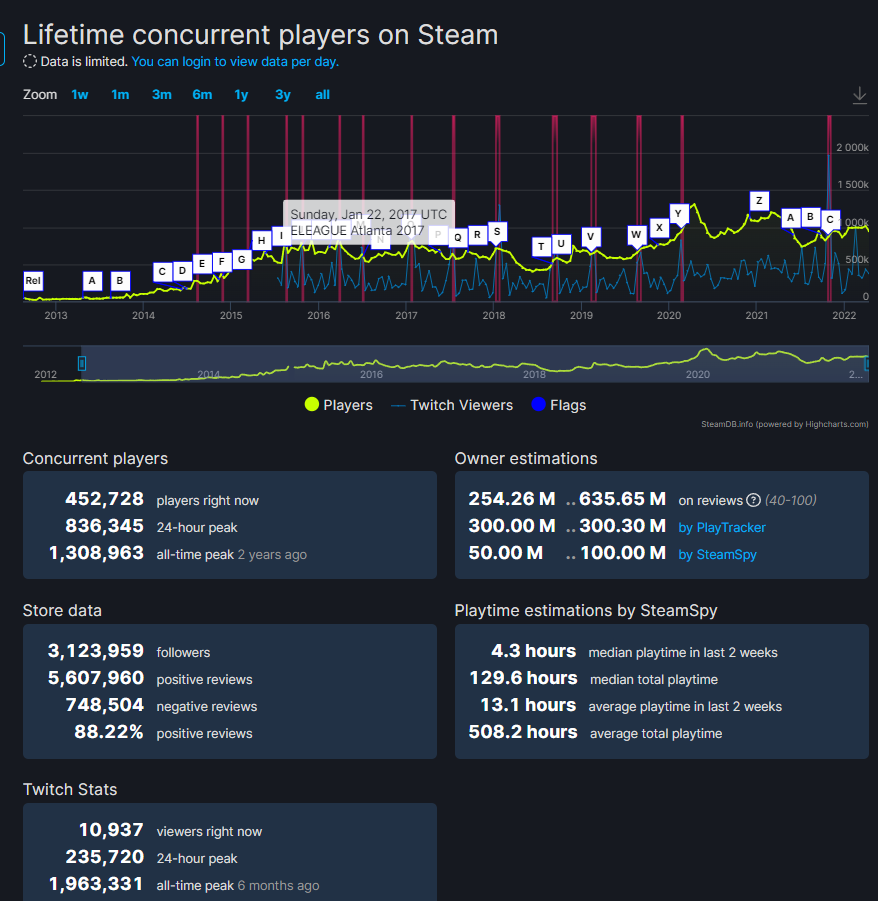

Peak Concurrent Users at least have similar values... Owners, since the ranges are so big, can also be similar. But why do the average and mean make no sense at all? Let's check another more recent game (Vampire Survivors):
https://steamdb.info/app/1794680/graphs/
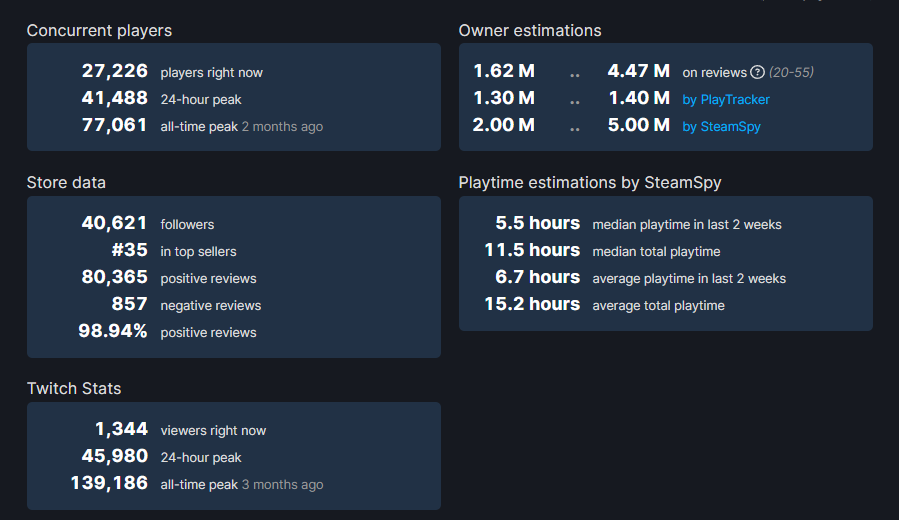

Ok, now I have an idea what might be happening. Let's check Vampire Survivors on Steam Spy: https://steamspy.com/app/1794680

We have around 15 hours of average total playtime (forever), and 11:30 hours of median total playtime (forever). Does that ring a bell? Yes, our values are in fact the amount of minutes played by the owners of the game.

These two variables are related and important, as they tell us how popular each game is right now and how much the users tend to stick with it. The averages and medians can tell us how engaged the gamers are, which if you have followed the video game ecosystem for the last few years, you will know it is quite important. Returning gamers can be enticed to buy further services or DLCs. This is very important for Free To Play games, but a lot of other games monetize them somehow after sales. This same thing happens on the mobile market, althought there it is much typical to offer the apps free and monetize after with IAP (In App Purchasing) or via adds. In steam, the most typical way is to offer the game for a set price, then possibly continue with some DLCs (Downloable Content, i.e Expansions), and in a few cases (although typical for the Free To Play) IAP.

In sort, if players play a lot of hours in your game, they are more likely to buy extra things for the game. They are also more likely to be interested in future games. This is mainly important in multiplayer or open games.

Of course there are big exceptions to this. We will not explore them fully as we lack time series data for "current" players, and it would be quite complex to represent. Note that this can be explored in SteamDB, see for instance CS:GO which is one of the healthier games (if not the most healthy) in player engagement: https://steamdb.info/app/730/graphs/

The third metric is important for steam as just selling the game is still one of the most important sources of revenue from a game (and a lot of times, the only source). This is very tricky, one way webpages estimate this is with the number of total reviews from a game which is public. See this discussion: https://www.resetera.com/threads/life-time-steamspy-owner-estimates-for-steam-titles-released-in-2019-2020-having-min-500-000-owners.273800/ and this one: https://www.reddit.com/r/gamedev/comments/emvtat/i_wrote_an_analysis_of_estimated_revenue_data_for/ . We will keep this data as is from steam spy, but we will possibly use instead the number of total reviews as an estimate of success, as we have granular data for all games in this format.

https://www.gamedeveloper.com/business/using-steam-reviews-to-estimate-sales See this post as it is extremely informative about this. Older games tend to have more sales per reviews, but the ranges are very big. Also it informs why steam spy changed, (before it offered an accurate number estimate) was changed due to steam policies (ownership of the games was public by default). Also Steam does not allow to publish your own sales numbers (as publisher or developer). We may give some big numbers but on the EDA chapter.

In [200]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66368 entries, 10 to 1968880
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 66203 non-null  object 
 1   developers           58132 non-null  object 
 2   publishers           58131 non-null  object 
 3   score_rank           48 non-null     float64
 4   positive             66368 non-null  int64  
 5   negative             66368 non-null  int64  
 6   userscore            66368 non-null  int64  
 7   owners               66368 non-null  object 
 8   average_forever      66368 non-null  int64  
 9   average_2weeks       66368 non-null  int64  
 10  median_forever       66368 non-null  int64  
 11  median_2weeks        66368 non-null  int64  
 12  price                58281 non-null  float64
 13  initialprice         58283 non-null  float64
 14  discount             58283 non-null  float64
 15  supported_languages  58241 non-nu

In [201]:
spy.loc[:,["name","average_forever","average_2weeks","median_forever","median_2weeks","ccu","owners"]].sort_values(by="ccu", ascending=False).head(20)

name  average_forever  average_2weeks  \
id                                                                           
730      Counter-Strike: Global Offensive            29520             814   
570                                Dota 2            41017            1476   
578080                PUBG: BATTLEGROUNDS            22161             640   
1599340                          Lost Ark             2335            1168   
1172470                      Apex Legends             4940             828   
1245620                        ELDEN RING             5337            1184   
271590                 Grand Theft Auto V            12441             667   
252490                               Rust            17212             752   
1203220                NARAKA: BLADEPOINT             7235            1268   
440                       Team Fortress 2             8058             435   
359550     Tom Clancy's Rainbow Six Siege            11874             434   
1085660                         Destiny 2             7328            1045   
346110              ARK: Survival Evolved            11818            1034   
1418630                      Dread Hunger             1736             727   
236390                        War Thunder             5171             868   
1569040             Football Manager 2022            12665            2241   
1794680                 Vampire Survivors             1027             439   
230410                           Warframe             9581             810   
1506830                           FIFA 22             6240             692   
289070        Sid Meier’s Civilization VI             8473            1035   

         median_forever  median_2weeks     ccu                      owners  
id                                                                          
730                6142            280  850167   50,000,000 .. 100,000,000  
570                1023            833  695682  100,000,000 .. 200,000,000  
578080             7366            202  483898   50,000,000 .. 100,000,000  
1599340             679            336  421971    20,000,000 .. 50,000,000  
1172470             682            485  343397    20,000,000 .. 50,000,000  
1245620            4731            672  281886    20,000,000 .. 50,000,000  
271590             6101            216  137526    20,000,000 .. 50,000,000  
252490             2904            274  129232    20,000,000 .. 50,000,000  
1203220            3093           1364  114791    10,000,000 .. 20,000,000  
440                 380            176   94797   50,000,000 .. 100,000,000  
359550             2350            156   78730    20,000,000 .. 50,000,000  
1085660             364            830   75934    20,000,000 .. 50,000,000  
346110             1157            839   72752    10,000,000 .. 20,000,000  
1418630            1145            623   70235        500,000 .. 1,000,000  
236390              309            309   68765    20,000,000 .. 50,000,000  
1569040           16369           4232   67125        500,000 .. 1,000,000  
1794680             841            360   63650      2,000,000 .. 5,000,000  
230410              379            338   62014    20,000,000 .. 50,000,000  
1506830            4127            521   56872      1,000,000 .. 2,000,000  
289070             1626            697   54923     5,000,000 .. 10,000,000

Now that we understand these values, are they in a good format and name? Not really. Also, four columns for playtime observations might be too much, but we will leave them as is. Also, in minutes it is hard to understand how much time has been played - We will change it to hours.

In [202]:
spy["average_forever"]= spy["average_forever"].apply(lambda x: x/60)
spy["average_2weeks"]= spy["average_2weeks"].apply(lambda x: x/60)
spy["median_forever"]= spy["median_forever"].apply(lambda x: x/60)
spy["median_2weeks"]= spy["median_2weeks"].apply(lambda x: x/60)

In [203]:
spy = spy.rename(columns = {'average_forever':'playtime_mean_forever', 'average_2weeks':'playtime_mean_last2weeks',
                     'median_forever':'playtime_median_forever', 'median_2weeks': 'playtime_median_last2weeks',
                     'ccu':'peak_players_17April2022'})

In [204]:
spy["peak_players_17April2022"].value_counts()

0         50600
1          4848
2          1995
3          1165
4           739
5           533
6           431
7           359
8           313
9           253
10          190
11          178
12          167
13          154
15          118
14          118
18          105
16           98
20           91
17           78
22           78
19           75
23           72
24           70
21           67
31           65
27           54
26           53
25           51
30           50
33           43
38           43
36           39
32           39
28           38
35           36
34           34
39           34
42           34
29           32
44           30
43           30
40           29
53           29
45           27
37           25
47           25
68           24
41           24
57           22
56           21
69           21
49           20
48           20
46           19
50           19
81           18
51           18
78           18
61           18
59           18
63           17
86      

In [205]:
spy["playtime_median_forever"].value_counts()

0.000000       54557
0.016667         287
0.033333         101
0.066667          82
0.166667          79
0.050000          76
0.100000          68
0.183333          67
0.250000          67
0.083333          65
0.116667          63
0.133333          62
0.150000          54
0.200000          53
0.283333          52
0.233333          52
0.266667          49
0.516667          48
0.216667          48
0.433333          48
0.300000          48
0.316667          45
0.533333          45
0.500000          43
0.333333          43
0.633333          42
0.466667          41
0.416667          41
0.450000          41
2.050000          40
3.616667          39
1.666667          37
0.583333          37
0.400000          37
0.566667          37
0.550000          36
0.783333          35
0.833333          35
2.066667          35
0.816667          35
0.483333          35
0.916667          34
4.050000          34
0.366667          34
3.150000          34
3.850000          34
2.283333          33
0.600000     

In [206]:
spy["playtime_median_last2weeks"].value_counts()

0.000000      65009
0.016667         65
0.033333         21
0.100000         18
0.133333         17
0.083333         15
0.066667         14
0.216667         13
0.116667         13
0.250000         12
0.050000         12
0.266667         12
0.316667         11
0.350000         11
0.500000         11
0.383333         11
0.150000         10
0.200000         10
0.600000         10
0.166667         10
0.650000         10
0.566667          9
1.016667          9
0.483333          8
1.550000          8
0.183333          8
0.233333          8
0.433333          8
0.966667          8
3.416667          8
0.850000          8
0.633333          7
2.766667          7
0.733333          7
0.800000          7
0.583333          7
0.550000          7
1.766667          7
0.366667          7
0.616667          7
2.750000          7
1.566667          7
0.816667          7
1.216667          7
1.266667          6
0.900000          6
0.700000          6
3.433333          6
0.450000          6
1.600000          6


We may have some issues from these values. Basically 0 can mean either it has not been observed, or that it is truly 0. One option could be to replace them with NaNs, but instead we will do the oposite and fill any NaNs with 0 and understand that it might be either unknown or really 0. In any case, if Steam Spy information is reliable, should be close to 0 if any.

Let's merge it with the main Dataframe and clean remaining NaNs.

In [207]:
spy = spy.drop(["name", "developers", "publishers", "score_rank", "positive", "negative",
                                  "userscore", "price", "initialprice", "discount", "supported_languages",
                                  "genres", "tags"], axis=1)
store = store.join(spy)
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66216 entries, 10 to 1973640
Data columns (total 65 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        66216 non-null  object 
 1   controller_support          66216 non-null  object 
 2   dlc                         66216 non-null  bool   
 3   detailed_description        66190 non-null  object 
 4   about_the_game              66189 non-null  object 
 5   short_description           66191 non-null  object 
 6   supported_languages         66216 non-null  object 
 7   header_image                66216 non-null  object 
 8   drm                         66216 non-null  bool   
 9   ext_user_account_notice     66216 non-null  object 
 10  developers                  66216 non-null  object 
 11  publishers                  66216 non-null  object 
 12  demos                       66216 non-null  bool   
 13  platforms                   

In [208]:
def fillNAwith0(df, columnlist):
    for column in columnlist:
        df[column] = df[column].fillna(0.0)
    return df

store = fillNAwith0(store, ['playtime_mean_forever', 'playtime_mean_last2weeks','playtime_median_forever',
                    'playtime_median_last2weeks','peak_players_17April2022', 'owners'])

In [209]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66216 entries, 10 to 1973640
Data columns (total 65 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        66216 non-null  object 
 1   controller_support          66216 non-null  object 
 2   dlc                         66216 non-null  bool   
 3   detailed_description        66190 non-null  object 
 4   about_the_game              66189 non-null  object 
 5   short_description           66191 non-null  object 
 6   supported_languages         66216 non-null  object 
 7   header_image                66216 non-null  object 
 8   drm                         66216 non-null  bool   
 9   ext_user_account_notice     66216 non-null  object 
 10  developers                  66216 non-null  object 
 11  publishers                  66216 non-null  object 
 12  demos                       66216 non-null  bool   
 13  platforms                   

## Final Cleaning
### Genres with NaNs

Of these columns, we will not deal with NaNs in the description columns as they will not be used for any Data visualization. If we apply any NLP techniques at a later point, we can just simply ignore rows with NaNs. We only care now for the rest of the metadata.

Let's see why we still have some NaNs in `genres`.

In [210]:
store["genres"].value_counts()

Action,Indie                                                                                                                                                                                                                                    4031
Casual,Indie                                                                                                                                                                                                                                    3672
Action,Adventure,Indie                                                                                                                                                                                                                          3505
Adventure,Indie                                                                                                                                                                                                                                 2919
Action,Casual,Indie 

In [211]:
getSteamLink(store[store["genres"].isna()])

Hot Dish https://store.steampowered.com/app/12570
Dr. Daisy Pet Vet https://store.steampowered.com/app/12580
Call of Cthulhu®: Dark Corners of the Earth https://store.steampowered.com/app/22340
Sonic 3D Blast™ https://store.steampowered.com/app/34278
Alex Kidd™ in the Enchanted Castle https://store.steampowered.com/app/34283
Kid Chameleon™ https://store.steampowered.com/app/34311
Ristar™ https://store.steampowered.com/app/34312
Decap Attack™ https://store.steampowered.com/app/34318
Sacrifice https://store.steampowered.com/app/38440
Nancy Drew® Dossier: Resorting to Danger! https://store.steampowered.com/app/42200
Air Forte https://store.steampowered.com/app/55020
ESWAT™: City Under Siege https://store.steampowered.com/app/71110
Flicky™ https://store.steampowered.com/app/71111
Sonic 3 & Knuckles https://store.steampowered.com/app/71162
ToeJam & Earl in Panic on Funkotron https://store.steampowered.com/app/71167
Wonder Boy III: Monster Lair https://store.steampowered.com/app/71168
Sonic 

Looking at these games, they may not have genres (defined by the publisher) but they at least have tags (defined by the customers). We could argue that the genre information from the API is obsolete and it would be best to simply using the tags. However, remember that tags are all about "popular/prominent" features, they do not really mean game without these tags do not have these features or themes...

If a game has a genre in the API it should mean the publisher has selected a specific genre or feature. So we should consider those values as the "true" genres of the game. But these games have publishers which did not add any... so let's try gathering similar / close genres from the tags for them, but only for these specific games without genres.

First we will need to know which genres we already have... And check which of them also exist as tags and where.

In [212]:
genreList = getTagListScrapped(store["genres"])
genreList

Indie                    48289
Action                   28958
Free to Play              4991
Strategy                 13019
Adventure                26914
RPG                      12417
Casual                   26296
Simulation               13411
Racing                    2416
Massively Multiplayer     1934
Nudity                     119
Violent                    531
Sports                    2951
Early Access              7646
Gore                       312
Sexual Content             108
Movie                        2
Audio Production             5
Education                   21
Software Training            6
Utilities                   12
Design & Illustration        9
Animation & Modeling         5
Web Publishing               4
Accounting                   3
Video Production             4
Game Development             8
Photo Editing                1
Documentary                  1
Episodic                     1
Short                        1
Tutorial                     1
360 Vide

In [213]:
for item in genreList.index:
    if item in steam_category_tags["tag"].values:
        print(item + " Yes")
    else:
        print(item + " No")

Indie Yes
Action Yes
Free to Play Yes
Strategy Yes
Adventure Yes
RPG Yes
Casual Yes
Simulation Yes
Racing Yes
Massively Multiplayer Yes
Nudity Yes
Violent Yes
Sports Yes
Early Access Yes
Gore Yes
Sexual Content Yes
Movie Yes
Audio Production Yes
Education Yes
Software Training Yes
Utilities Yes
Design & Illustration Yes
Animation & Modeling Yes
Web Publishing Yes
Accounting No
Video Production Yes
Game Development Yes
Photo Editing Yes
Documentary Yes
Episodic Yes
Short Yes
Tutorial Yes
360 Video Yes


This means that every genre (apart from Accounting ¿?) has a tag with the same name. Which makes sense, as it seems that at least from the point of view of a customer, genres are indistinguishable from tags. Some people believe that genres and categories are what the publishers can "add" to a game, and Tags are mainly customer curated, but I think that is not the case - customers can add any kind of Tag to a game, or at least, publisher-only Tags are Tags, not genres (and probably only linked to features).

If not, we would not have games without the "casual" or "single player" genre but with a Tag indicating this, and if you check the games above that is certainly the case.

It is curious to see that if you try to search "Accounting" games on steam, you fail:
https://store.steampowered.com/tags/en/Accounting/ but it does not throw you into the main webpage as if you introduced a false Tag ( https://store.steampowered.com/tags/en/Valygar/ ). So this is probably an oversight on Steam side... Or accounting is available as a Tag but no game has chosen it, which is weird because we have games about that...

Which brings us to an interesting point. Should we ditch genres entirely since all exist as tags? We did that with the column `categories`, that was transformed instead in a few useful feature columns, but in that case there were some meta features which are not included in the tags.

For the time being let's put genre-tags into the genres columns where we have games without a single genre.

In [214]:
store[store["genres"].isna()]["tag_list"]

id
12570                                                                                                                                                                                                                                                               ,Cooking,Casual,
12580                                                                                                                                                                                                                                                       ,Time Management,Casual,
22340                                                            ,Lovecraftian,Horror,First-Person,Survival Horror,Atmospheric,Based On A Novel,FPS,Stealth,Singleplayer,Adventure,Story Rich,Classic,Action,Survival,Shooter,Psychological Horror,Dark,Gore,Difficult,Cult Classic,
34278                                                                                                                                                  ,Platformer,Sin

In [215]:
def transferTagsIntoGenres(df):
    for index, item in df[df["genres"].isna()]["tag_list"].str.split(pat=",").items():
        for tag in item:
            if tag in genreList.index:
                if (pd.isna(df.loc[index,"genres"])):
                    df.at[index,"genres"] = tag
                else:
                    df.at[index,"genres"] = df.at[index,"genres"]+","+tag
    return df

In [216]:
store = transferTagsIntoGenres(store)
store[store["genres"].isna()]["tag_list"]

id
34311                                                                                                                                                                                                                                                             ,Platformer,Retro,
34312                                                                                                                                                                                                                          ,Platformer,Classic,Singleplayer,2D,Great Soundtrack,
34318                                                                                                                                                                                                                                                                ,Platformer,2D,
71111                                                                                                                                                                 

In [217]:
getSteamLink(store[store["genres"].isna()])

Kid Chameleon™ https://store.steampowered.com/app/34311
Ristar™ https://store.steampowered.com/app/34312
Decap Attack™ https://store.steampowered.com/app/34318
Flicky™ https://store.steampowered.com/app/71111
ToeJam & Earl in Panic on Funkotron https://store.steampowered.com/app/71167
Dynamite Headdy https://store.steampowered.com/app/211201
Wonder Boy in Monster World https://store.steampowered.com/app/211209
7 Days to Die Dedicated Server https://store.steampowered.com/app/294420
Defense Grid 2: A Matter of Endurance https://store.steampowered.com/app/312860
Emerge: Cities of the Apocalypse https://store.steampowered.com/app/457600
Avatar of the Wolf https://store.steampowered.com/app/643570
AngerForce: Reloaded https://store.steampowered.com/app/650780
M.I.A. - Overture https://store.steampowered.com/app/712060
Proto-G https://store.steampowered.com/app/975750
preparation https://store.steampowered.com/app/982420
OXENFREE II: Lost Signals https://store.steampowered.com/app/1574310


Looking at the rest of the values, we got some retro games published by SEGA, some games that have not been released yet, some that should not be considered games. A few that have been delisted. We will delete some of them and keep the rest, because they are valid games, just without genres associated.

If we cared a lot, we could try assigning them genres manually. Action, Adventure or Strategy would fit most of them. But I prefer to remove points of the dataset which should not be included, instead of adding "extra" information. Otherwise, if we refresh the databases we would need to look manually again for these specific cases.

In [218]:
store = store.drop(index=[982420, 294420])

In [219]:
store[store["genres"].isna()]

name controller_support    dlc  \
id                                                                         
34311                           Kid Chameleon™            partial  False   
34312                                  Ristar™            partial  False   
34318                            Decap Attack™            partial  False   
71111                                  Flicky™            partial  False   
71167      ToeJam & Earl in Panic on Funkotron            partial  False   
211201                         Dynamite Headdy               none  False   
211209             Wonder Boy in Monster World               none  False   
312860   Defense Grid 2: A Matter of Endurance               none  False   
457600        Emerge: Cities of the Apocalypse               none  False   
643570                      Avatar of the Wolf               none  False   
650780                    AngerForce: Reloaded            partial  False   
712060                       M.I.A. - Overture               none  False   
975750                                 Proto-G            partial  False   
1574310              OXENFREE II: Lost Signals               none  False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

### Release Date Missing Data

Another thing to consider now that we have more information is the `release_date` column. We had some unknown dates there (not coming_soon, but no date) that might be interesting to confirm if we can extract through steam spy.

In [220]:
store["release_date"].value_counts()

coming_soon            10956
2020-01-17 00:00:00       82
2021-09-30 00:00:00       82
2021-10-14 00:00:00       80
2022-01-21 00:00:00       77
2021-12-15 00:00:00       76
2020-10-15 00:00:00       74
2021-10-08 00:00:00       70
2021-04-30 00:00:00       70
2021-06-17 00:00:00       70
2021-10-29 00:00:00       69
2021-06-04 00:00:00       68
2021-02-18 00:00:00       67
2021-02-26 00:00:00       66
2021-11-11 00:00:00       66
2021-10-01 00:00:00       66
2021-10-22 00:00:00       66
2021-10-21 00:00:00       65
2021-07-29 00:00:00       65
2020-10-30 00:00:00       65
2021-12-03 00:00:00       64
2021-07-30 00:00:00       64
2020-07-31 00:00:00       63
2021-11-19 00:00:00       61
2021-12-16 00:00:00       61
2022-03-04 00:00:00       61
2022-03-01 00:00:00       60
2021-11-04 00:00:00       60
2021-09-09 00:00:00       60
2020-12-04 00:00:00       60
2021-04-15 00:00:00       60
2021-08-13 00:00:00       59
2021-08-26 00:00:00       59
2022-01-07 00:00:00       59
2021-10-28 00:

In [221]:
getSteamLink(store[store["release_date"] == "unknown"])

Borderlands Game of the Year https://store.steampowered.com/app/8980
Sherlock Holmes: The Mystery of the Persian Carpet https://store.steampowered.com/app/11180
Penumbra: Requiem https://store.steampowered.com/app/22140
Trainz: Murchison 2 https://store.steampowered.com/app/24660
Sam & Max 302: The Tomb of Sammun-Mak https://store.steampowered.com/app/31230
Sam & Max 303: They Stole Max's Brain! https://store.steampowered.com/app/31240
Sam & Max 304: Beyond the Alley of the Dolls https://store.steampowered.com/app/31250
Sam & Max 305: The City That Dares Not Sleep https://store.steampowered.com/app/31260
The Great Art Race https://store.steampowered.com/app/33580
Prison Tycoon 4: SuperMax https://store.steampowered.com/app/33750
Arma 2 https://store.steampowered.com/app/33900
Tradewinds Caravans + Odyssey Pack https://store.steampowered.com/app/36130
Westward Collection https://store.steampowered.com/app/36150
SpellForce 2 - Anniversary Edition https://store.steampowered.com/app/39550


In [222]:
print("Number of games with an unknown release date: ", (store["release_date"] == "unknown").sum()/(store["release_date"] == "unknown").count()*100, "%")

Number of games with an unknown release date:  0.0800434953333132 %


Looking at their steam webpages, almost all have user reviews. Some of them can be bought so the date might be an error, some have been discontinued, some have been replaced by an upgraded version...
There are also a few "non games" such as Steam VR or tools for specific games.

In this case, we cannot get the information from another place as steam spy does not offer it in the api. Web scrapping in the steam store would not be useful.
The only way would be to manually check each entry and add it. taking into account that this is less than 0.2%, we will just live with the fact that these will not be used in any time graph.

However there is an even bigger concern...

In [223]:
print("Number of games with a coming soon release date: ", (store["release_date"] == "coming_soon").sum()/(store["release_date"] == "unknown").count()*100, "%")

Number of games with a coming soon release date:  16.546349714561874 %


Can this be true, that steam has so many games unreleased? Let's check how many of them have reviews, which means they were released at some point...

In [224]:
getSteamLink(store[((store["release_date"] == "coming_soon") & (store["total_reviews"] >0))])

Tetrapulse https://store.steampowered.com/app/250440
Battle of Kings https://store.steampowered.com/app/779300
Slimy Sextet https://store.steampowered.com/app/1189070


The number may vary, but the first time this was performed, there were a few errors and also we got games that were released close to the time where we obtained the raw data. The first time I got here I had to download the reviews about 40 days after, so the games that have been released during that time have reviews and an updated review date, but the steam database was not updated so the game was still listed as "unreleased".

After seeing this, I decided to redownload all the information and make sure everything is correct, with much better results (which should be what you are seeing right now).

The games with more than 0 reviews now but no release date: most are from the release date of the day the data was extracted, while some are delisted games. They are very few so we can leave them as is.

And well, it is true there are a lot of Coming Soon games on steam. If you look into the releases (more of that in the next chapter), you will see that recent years have a lot more releases. Also there might be a lot of "abandoned" projects. At the moment is unknown if Steam does any sort of cleaning with these projects, as unlisted games (not shown in the search or purchaseable) seems to be a publisher decision...

Let's inspect the store dataframe and see how it looks in regards to column information and NaNs...

In [225]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66214 entries, 10 to 1973640
Data columns (total 65 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        66214 non-null  object 
 1   controller_support          66214 non-null  object 
 2   dlc                         66214 non-null  bool   
 3   detailed_description        66190 non-null  object 
 4   about_the_game              66189 non-null  object 
 5   short_description           66190 non-null  object 
 6   supported_languages         66214 non-null  object 
 7   header_image                66214 non-null  object 
 8   drm                         66214 non-null  bool   
 9   ext_user_account_notice     66214 non-null  object 
 10  developers                  66214 non-null  object 
 11  publishers                  66214 non-null  object 
 12  demos                       66214 non-null  bool   
 13  platforms                   

Let's move a few of these columns so similar columns are closer to each other.

In [226]:
store = store[['name',
 'detailed_description',
 'about_the_game',
 'short_description',
 'header_image',
 'developers',
 'publishers',
 'platforms',
 'release_date',
 'initialprice',
 'drm',
 'ext_user_account_notice',
 'controller_support',
 'dlc',
 'demos',
 'deck_compatibility',
 'vr_only',
 'vr_supported',
 'vr_pcinput',
 'singleplayer',
 'multiplayer',
 'pvp',
 'co-op',
 'online',
 'local_multiplayer',
 'mmo',
 'lan',
 'achievements',
 'cloud',
 'trading_cards',
 'leaderboards',
 'workshop',
 'in_app_purchases',
 'level_editor',
 'early_access',
 'mature',
 'tag_list',
 'genres',
 'Tags - Top-Level Genres',
 'Tags - Genres',
 'Tags - Sub-Genres',
 'Tags - Visuals & Viewpoint',
 'Tags - Themes & Moods',
 'Tags - Features',
 'Tags - Players',
 'Tags - Other Tags',
 'Tags - Software',
 'Tags - Assessments',
 'Tags - Maturity Ratings',
 'Tags - Hardware or Input',
 'Tags - Funding',
 'supported_languages',
 'voice_languages',
 'metacritic',
 'reviews',
 'total_positive',
 'total_negative',
 'total_reviews',
 'rating',
 'playtime_mean_forever', 
 'playtime_median_forever',
 'playtime_mean_last2weeks',
 'playtime_median_last2weeks',
 'peak_players_17April2022',
 'owners']]
store = store.drop(columns=["tag_list"])

## Storing Cleaned Dataframes

We have reviewed the store dataframe in detail in the last steps so we only need to store it to a csv file.

We also have a separated file (called extra) with different metadata. Note that it might have ids which have been deleted from the other dataframe, but all ids from the main dataframe are available on this extra dataframe.

In [227]:
extra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66216 entries, 10 to 1973640
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   name                66216 non-null  object
 1   support_info        66216 non-null  object
 2   header_image        66216 non-null  object
 3   website             35123 non-null  object
 4   pc_requirements     66216 non-null  object
 5   mac_requirements    66216 non-null  object
 6   linux_requirements  66216 non-null  object
 7   background          66155 non-null  object
 8   screenshots         66143 non-null  object
 9   movies              61320 non-null  object
dtypes: object(10)
memory usage: 5.6+ MB


In [228]:
extra.to_csv("../data/final/extra_metadata.csv")

In [229]:
store.to_csv("../data/final/steam_games.csv")

We can look further on that data, but for this moment the database can be finally be considered clean, and we are ready to move into the Exploratory Data Analysis.